In [142]:
import os
import numpy as np
from tqdm import tqdm
import random
from PIL import Image
import concurrent.futures
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from multiprocessing import Pool
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, transform, feature
import pandas as pd
from skimage.feature import canny
from skimage.transform import resize
import cv2

In [2]:
dir = r"C:\Users\Anwender\Desktop\Nicolas\Dokumente\FH Bielefeld\Optimierung und Simulation\2. Semester\SimulationOptischerSysteme\AI-Weather-Classification\dataset"

In [3]:
def load_images(base_path: str) -> dict:
    image_classname_dict = dict()

    # List each sub-directory in the base directory
    for folder in tqdm(os.listdir(base_path)):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            image_classname_dict[folder] = list()
            # List each image in the sub-directory
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file_path.endswith('.jpg'):  # check for jpg images
                    image = Image.open(file_path)
                    image = image.convert('RGB')  # Convert image to RGB
                    image_classname_dict[folder].append(np.array(image))
                else:
                    file_end = file_path.split(".")[-1]
                    print(f"File ends not with .jpg. Ends with: {file_end}")

    return image_classname_dict

In [4]:
image_classnames = load_images(dir)

100%|██████████| 11/11 [00:25<00:00,  2.33s/it]


In [5]:
# All labels
image_classnames.keys()

dict_keys(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow'])

In [6]:
# Shape of images
for key, value in image_classnames.items():
    img = value[0]
    print(f"Shape: {img.shape}")
    break

Shape: (675, 950, 3)


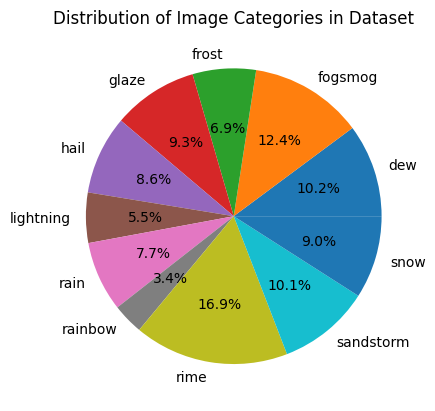

In [7]:
# Print pie chart
class_freq = {class_name: len(images) for class_name, images in image_classnames.items()}
plt.pie(class_freq.values(), labels=class_freq.keys(), autopct='%1.1f%%')
plt.title("Distribution of Image Categories in Dataset")
plt.show()

# Analysis of distribution of classes in dataset

Most of the classes are equally represented but rainbow is with 3.4% a little bit underepresendet where rime and fogsmog is a little bit overrepresented with 16.9% and 12.4%. 

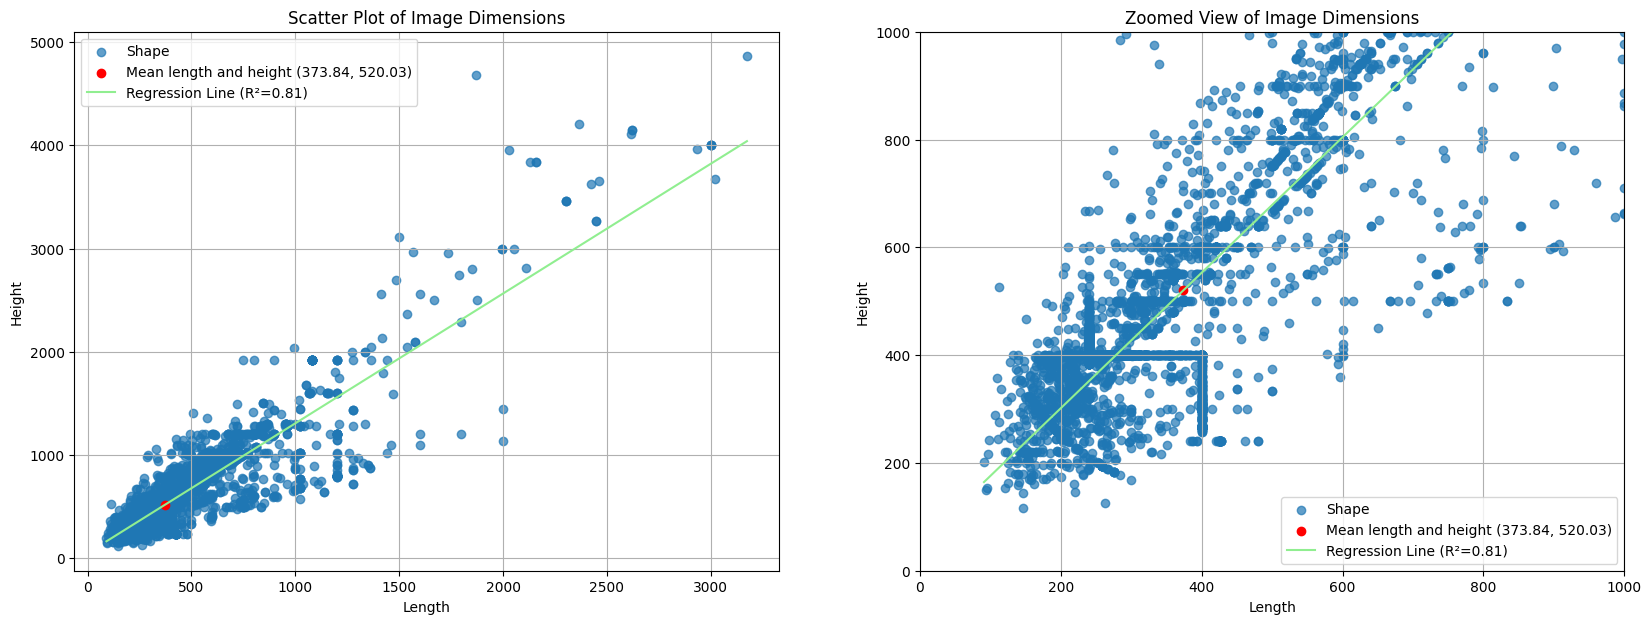

In [8]:
# Plot shape of all images
shapes_x = []
shapes_y = []
for image_class in image_classnames.values():
    for image in image_class:
        shapes_x.append(image.shape[0])
        shapes_y.append(image.shape[1])

shapes_x = np.array(shapes_x)
shapes_y = np.array(shapes_y)

# Calculate mean
mean_x = np.mean(shapes_x)
mean_y = np.mean(shapes_y)

# Calculate linear regression and R²
slope, intercept = np.polyfit(shapes_x, shapes_y, 1)
regression_x = np.linspace(min(shapes_x), max(shapes_x), 100)
regression_y = slope * regression_x + intercept
predicted_y = slope * shapes_x + intercept
r_squared = r2_score(shapes_y, predicted_y)
    
# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 7))  # Two subplots side by side

# First subplot: All data points and the regression line
axs[0].scatter(shapes_x, shapes_y, label="Shape", alpha=0.7)
axs[0].scatter(mean_x, mean_y, color="red", label=f"Mean length and height ({round(mean_x, 2)}, {round(mean_y, 2)})")
axs[0].plot(regression_x, regression_y, color="lightgreen", label=f"Regression Line (R²={round(r_squared, 2)})")
axs[0].grid()
axs[0].legend()
axs[0].set_title("Scatter Plot of Image Dimensions")
axs[0].set_xlabel("Length")
axs[0].set_ylabel("Height")

# Second subplot: Zoomed-in view with limited x and y axes
axs[1].scatter(shapes_x, shapes_y, label="Shape", alpha=0.7)
axs[1].scatter(mean_x, mean_y, color="red", label=f"Mean length and height ({round(mean_x, 2)}, {round(mean_y, 2)})")
axs[1].plot(regression_x, regression_y, color="lightgreen", label=f"Regression Line (R²={round(r_squared, 2)})")
axs[1].set_xlim([0, 1000])  # Limiting x-axis
axs[1].set_ylim([0, 1000])  # Limiting y-axis
axs[1].grid()
axs[1].legend()
axs[1].set_title("Zoomed View of Image Dimensions")
axs[1].set_xlabel("Length")
axs[1].set_ylabel("Height")

plt.show()

In [9]:
image_resize_sizes = [(2**size, 2**size) for size in range(1, 20)]
def euclidean_distance(point1: int, point2: int) -> float:
    return float(np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2))
# Find the tuple in image_resize_sizes that is closest to (mean_x, mean_y)
closest_size = None
min_distance = float('inf')  # Start with an infinitely large distance

for size in image_resize_sizes:
    distance = euclidean_distance(size, (mean_x, mean_y))
    if distance < min_distance:
        min_distance = distance
        closest_size = size
print(f"The closest size to the mean values ({mean_x}, {mean_y}) is {closest_size}")


The closest size to the mean values (373.8417371028855, 520.0297289419995) is (512, 512)


Start analyze rgb distribution


100%|██████████| 11/11 [01:50<00:00, 10.07s/it]


Analyze rgb distribution finished


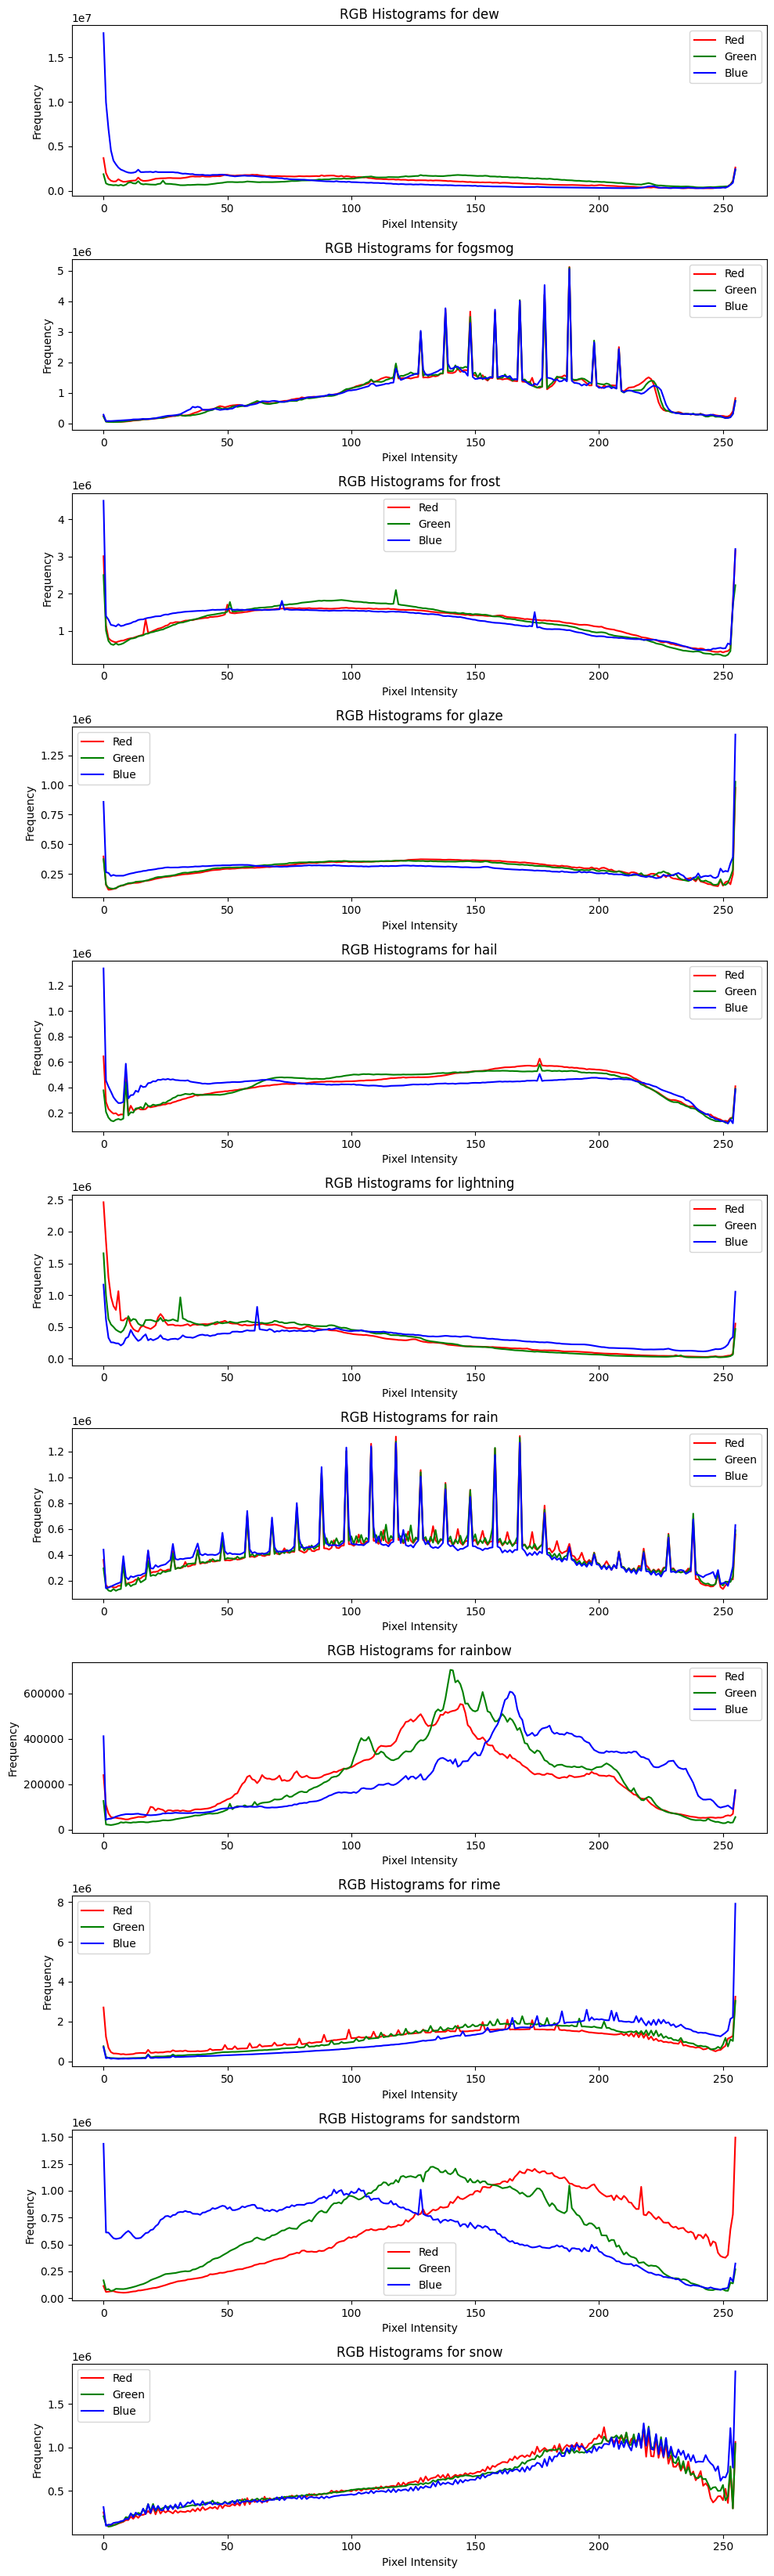

In [10]:
def analyze_rgb_distribution(image_classname_dict: dict) -> dict:
    class_histograms = {}
    bins = np.linspace(0, 256, 257)
    
    for class_name, images in tqdm(image_classname_dict.items()):
        # Use lists to collect data
        all_reds = []
        all_greens = []
        all_blues = []

        for image in images:
            all_reds.append(image[:,:,0].flatten())
            all_greens.append(image[:,:,1].flatten())
            all_blues.append(image[:,:,2].flatten())

        # Convert lists to arrays only once per channel per class
        all_reds = np.concatenate(all_reds)
        all_greens = np.concatenate(all_greens)
        all_blues = np.concatenate(all_blues)

        # Calculate histograms
        red_hist, _ = np.histogram(all_reds, bins=bins)
        green_hist, _ = np.histogram(all_greens, bins=bins)
        blue_hist, _ = np.histogram(all_blues, bins=bins)

        class_histograms[class_name] = {
            'red_hist': red_hist,
            'green_hist': green_hist,
            'blue_hist': blue_hist
        }

    return class_histograms


# Analyze RGB distributions
print("Start analyze rgb distribution")
rgb_histograms = analyze_rgb_distribution(image_classnames)
print("Analyze rgb distribution finished")

# Determine the number of classes
num_classes = len(rgb_histograms)
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 3 * num_classes))  # Adjust the size as needed

# Check if there is only one class to avoid indexing issues
if num_classes == 1:
    axes = [axes]

# Plot each class's histograms in a subplot
for ax, (class_name, histograms) in zip(axes, rgb_histograms.items()):
    ax.plot(histograms['red_hist'], color='red', label='Red')
    ax.plot(histograms['green_hist'], color='green', label='Green')
    ax.plot(histograms['blue_hist'], color='blue', label='Blue')
    ax.set_title(f'RGB Histograms for {class_name}')
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
def analyze_rgb_distribution_2(image_classname_dict: dict) -> dict:
    class_histograms = {}
    # Define bins for histograms
    bins = np.linspace(0, 256, 257)
    
    for class_name, images in (image_classname_dict.items()):
        # Aggregate RGB channels data
        all_reds = np.array([])
        all_greens = np.array([])
        all_blues = np.array([])

        for image in tqdm(images):
            all_reds = np.concatenate([all_reds, image[:,:,0].flatten()])
            all_greens = np.concatenate([all_greens, image[:,:,1].flatten()])
            all_blues = np.concatenate([all_blues, image[:,:,2].flatten()])

        # Calculate histograms
        red_hist, _ = np.histogram(all_reds, bins=bins)
        green_hist, _ = np.histogram(all_greens, bins=bins)
        blue_hist, _ = np.histogram(all_blues, bins=bins)

        class_histograms[class_name] = {
            'red_hist': red_hist,
            'green_hist': green_hist,
            'blue_hist': blue_hist
        }

    return class_histograms

In [12]:
def load_images_and_calculate_histograms(base_path: str) -> dict:
    class_histograms = {}
    bins = np.linspace(0, 256, 257)  # Define bins for histograms

    for folder in tqdm(os.listdir(base_path)):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            # Initialize histograms for this class
            histograms = {
                'red_hist': np.zeros(len(bins) - 1),
                'green_hist': np.zeros(len(bins) - 1),
                'blue_hist': np.zeros(len(bins) - 1)
            }
            
            # Process each image in the sub-directory
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file_path.endswith('.jpg'):  # Check for jpg images
                    image = Image.open(file_path)
                    image = image.convert('RGB')  # Convert image to RGB
                    data = np.array(image)

                    # Calculate histograms and update existing histograms
                    for color_index, key in enumerate(['red_hist', 'green_hist', 'blue_hist']):
                        hist, _ = np.histogram(data[:, :, color_index].flatten(), bins=bins)
                        histograms[key] += hist
                else:
                    print(f"Skipping file {file} as it does not end with .jpg")
            
            class_histograms[folder] = histograms
                    
    return class_histograms

def plot_class_rgb_histograms(class_rgb_values):
    for class_name, colors in class_rgb_values.items():
        plt.figure(figsize=(12, 4))
        plt.hist(colors['red_hist'], bins=256, color='red', alpha=0.5, label='Red')
        plt.hist(colors['green_hist'], bins=256, color='green', alpha=0.5, label='Green')
        plt.hist(colors['blue_hist'], bins=256, color='blue', alpha=0.5, label='Blue')
        plt.title(f'RGB Histograms for {class_name}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

In [13]:
class_rgb_values = load_images_and_calculate_histograms(dir)

100%|██████████| 11/11 [02:13<00:00, 12.13s/it]


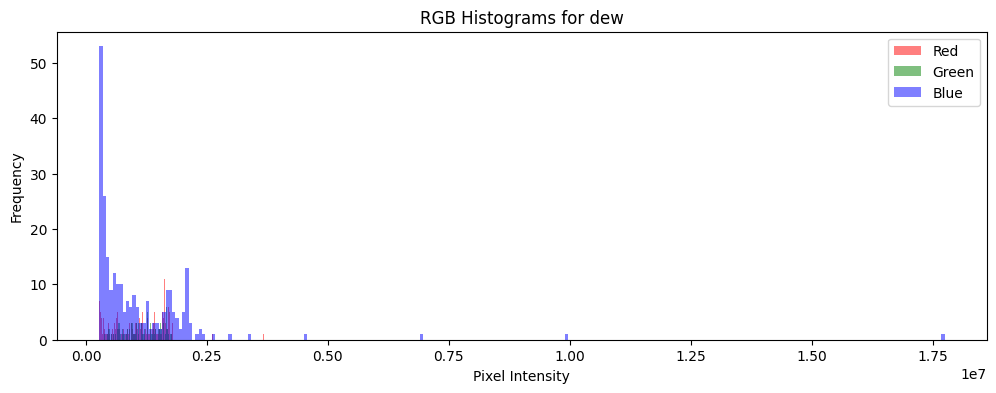

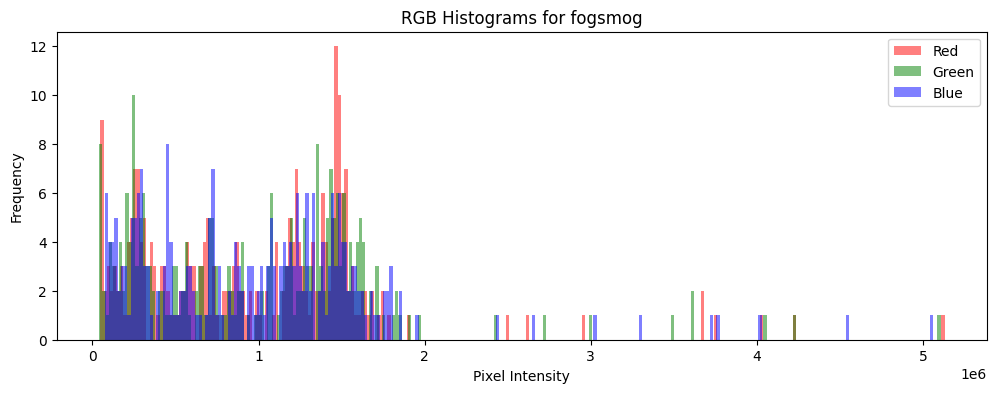

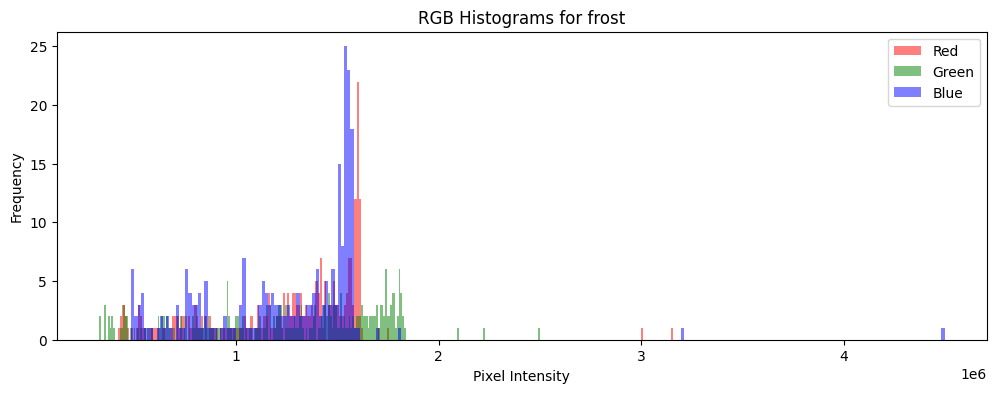

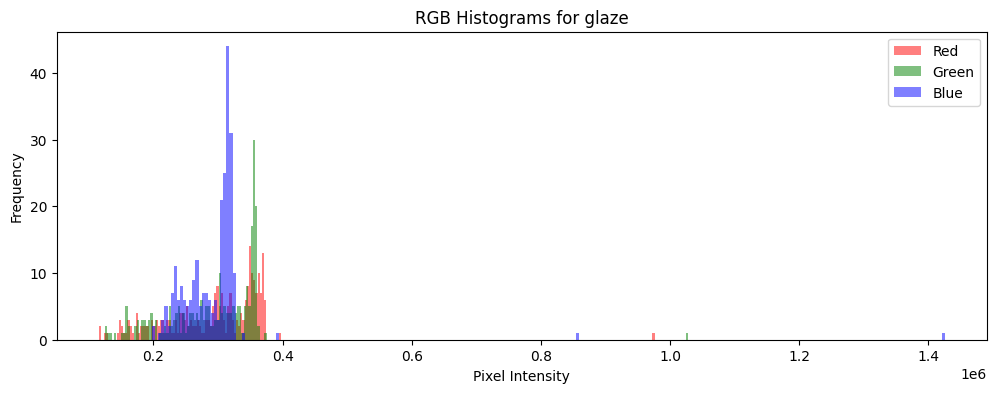

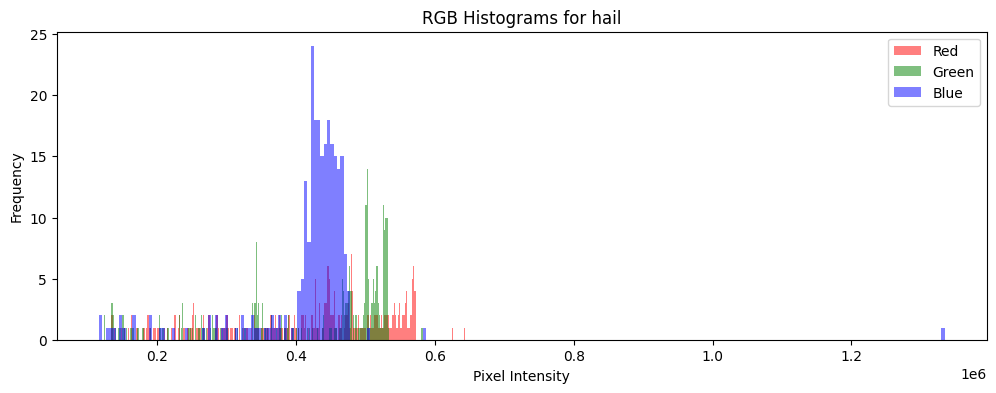

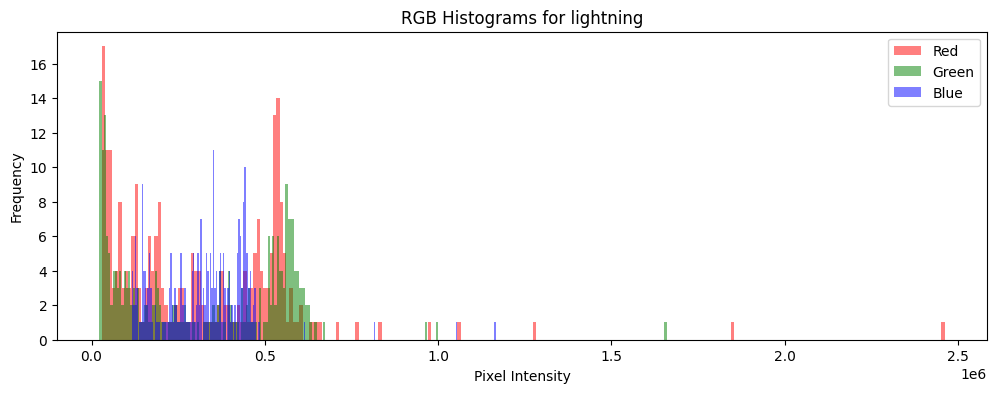

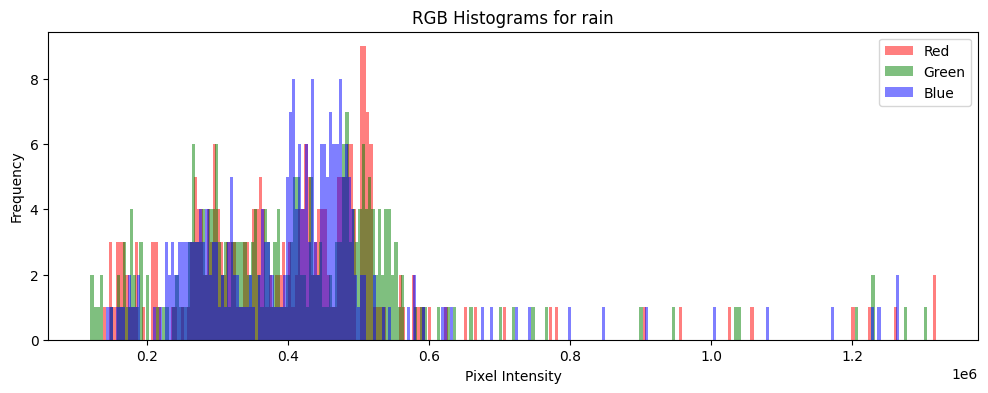

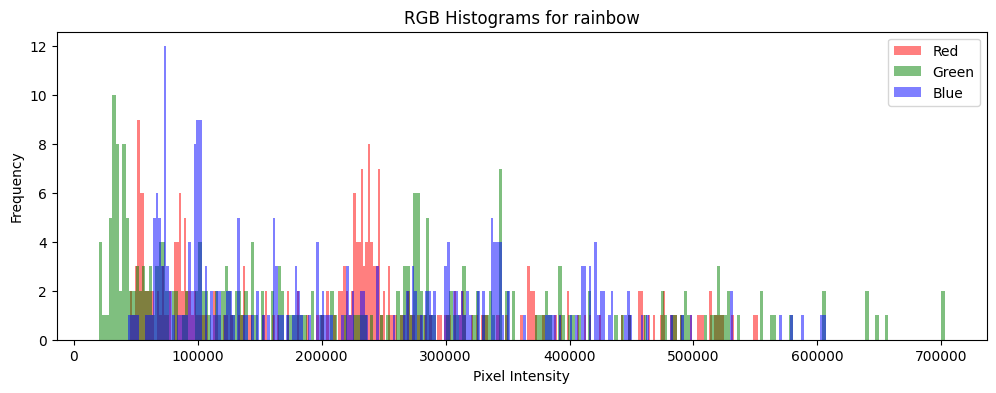

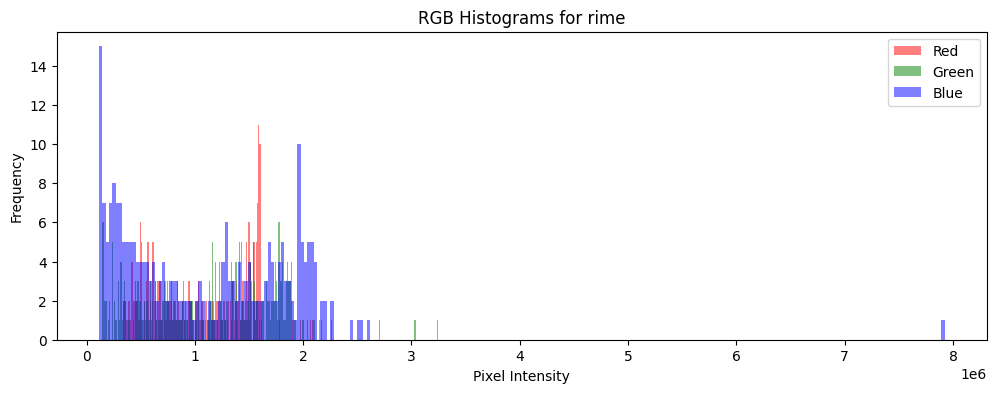

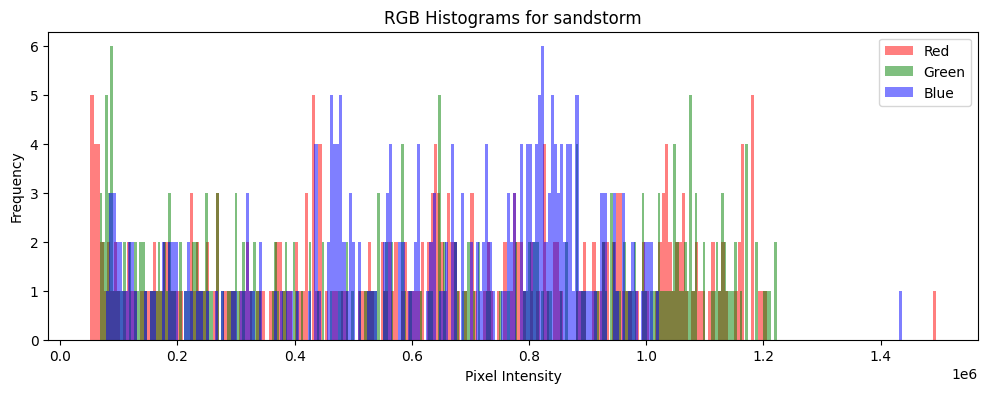

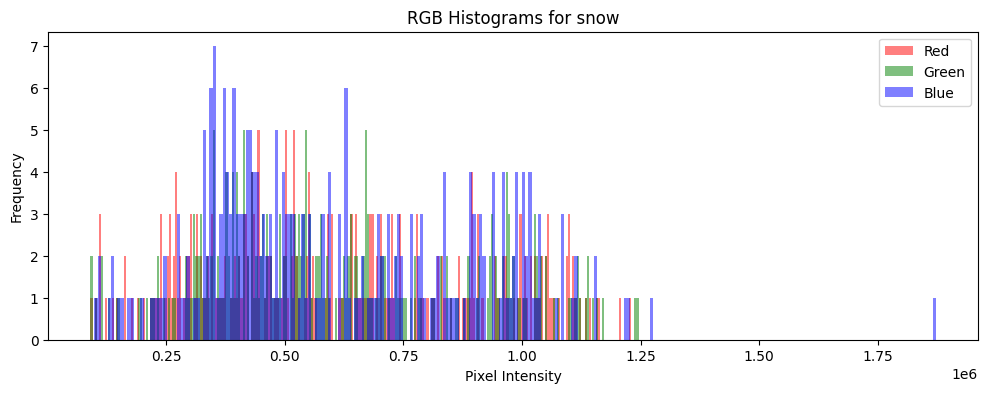

In [14]:
plot_class_rgb_histograms(class_rgb_values)

In [15]:
def glcm_analysis(path: str) -> pd.DataFrame:
    glcm_data = []  # List to store the data
    column_names = ['Class', 'file', 'Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']
    
    for folder in tqdm(os.listdir(path)):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for img in os.listdir(folder_path):
                image_file = os.path.join(folder_path, img)
                image = io.imread(image_file)
                # image = resize(image, (512, 512), anti_aliasing=True)
                
                # Correct resizing depending on the image dimensions
                if image.ndim == 2:  # Grayscale image
                    image_resized = resize(image, (512, 512), anti_aliasing=True)
                    image_gray = image_resized
                elif image.ndim == 3:
                    if image.shape[2] == 4:  # RGBA image
                        image = color.rgba2rgb(image)  # Convert to RGB
                    image_resized = resize(image, (512, 512, image.shape[2]), anti_aliasing=True)
                    image_gray = color.rgb2gray(image_resized)  # Convert to grayscale


                # Compute the GLCM matrix
                glcm = graycomatrix((image_gray * 255).astype('uint8'), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
                
                # Compute GLCM properties
                contrast = graycoprops(glcm, 'contrast')[0][0]
                dissimilarity = graycoprops(glcm, 'dissimilarity')[0][0]
                homogeneity = graycoprops(glcm, 'homogeneity')[0][0]
                energy = graycoprops(glcm, 'energy')[0][0]
                correlation = graycoprops(glcm, 'correlation')[0][0]

                # Append to list
                glcm_data.append([folder, img, contrast, dissimilarity, homogeneity, energy, correlation])

    # Create DataFrame from collected data
    df_glcm = pd.DataFrame(glcm_data, columns=column_names)
    return df_glcm

In [16]:
g = glcm_analysis(dir)
g

100%|██████████| 11/11 [04:50<00:00, 26.37s/it]


Class      file    Contrast  Dissimilarity  Homogeneity    Energy  \
0      dew  2208.jpg   26.752710       2.190837     0.479384  0.037652   
1      dew  2209.jpg   38.506700       2.625677     0.507965  0.041297   
2      dew  2210.jpg  125.461572       6.009655     0.246141  0.022015   
3      dew  2211.jpg   42.792716       2.693585     0.515090  0.040430   
4      dew  2212.jpg   51.523101       3.300888     0.439129  0.056251   
...    ...       ...         ...            ...          ...       ...   
6857  snow  1446.jpg  577.576416      13.783471     0.316991  0.200796   
6858  snow  1447.jpg  531.138301      11.887170     0.289319  0.036030   
6859  snow  1448.jpg  829.610766      18.081618     0.178514  0.012762   
6860  snow  1449.jpg  812.800644      18.933793     0.095714  0.010343   
6861  snow  1450.jpg  782.821734      18.989520     0.118058  0.026273   

      Correlation  
0        0.990246  
1        0.986858  
2        0.960716  
3        0.993747  
4        0.955714  
...           ...  
6857     0.939313  
6858     0.929795  
6859     0.902495  
6860     0.932998  
6861     0.899502  

[6862 rows x 7 columns]

In [85]:
def plot_g_column(column_name: str):

    class_names = g["Class"].unique()

    # Group by 'Class' and pick 'Contrast' for plotting
    class_contrast = list(g.groupby("Class")["Contrast"])

    # Determine the size of the grid
    n_classes = len(class_contrast)
    n_cols = 3
    n_rows = (n_classes + n_cols - 1) // n_cols  # This ensures we have enough rows

    # Create subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figsize accordingly
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    # Plot data
    for i, (class_name, values) in enumerate(class_contrast):
        values_x = np.arange(len(values))  # Using a simple range for x values
        axs[i].scatter(values_x, values, label=f"Contrast of {class_name}")
        axs[i].set_title(f"Class: {class_name}")
        axs[i].set_xlabel("Sample Index")
        axs[i].set_ylabel("Contrast")
        axs[i].legend()
        axs[i].grid(True)

    # Hide unused subplots if there are any
    for j in range(i + 1, n_rows * n_cols):
        axs[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

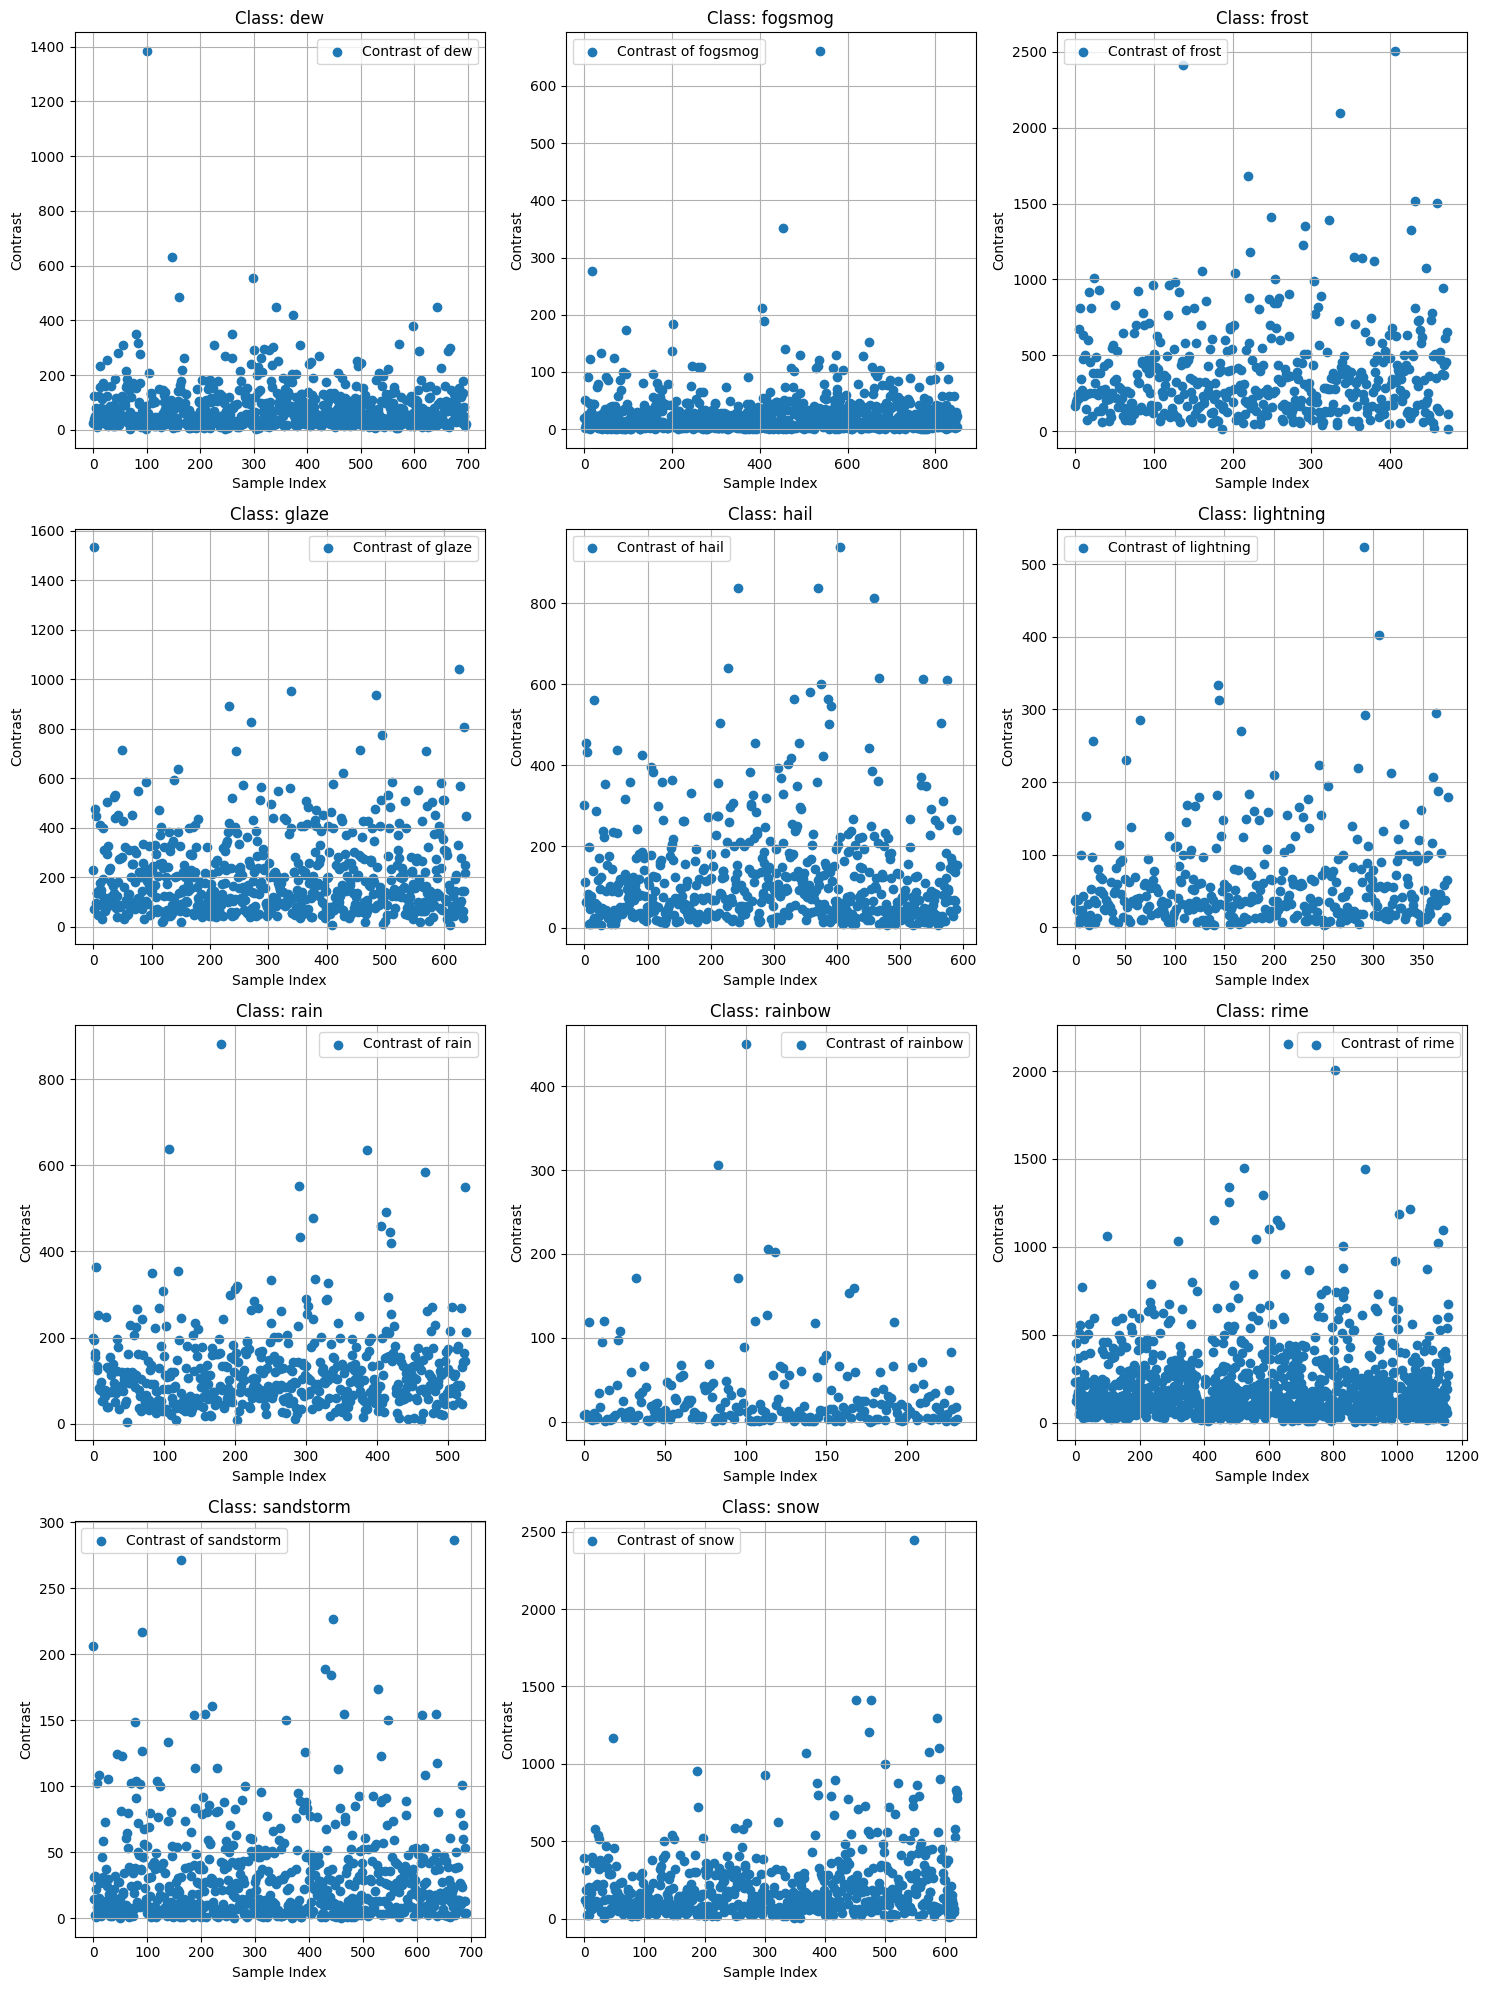

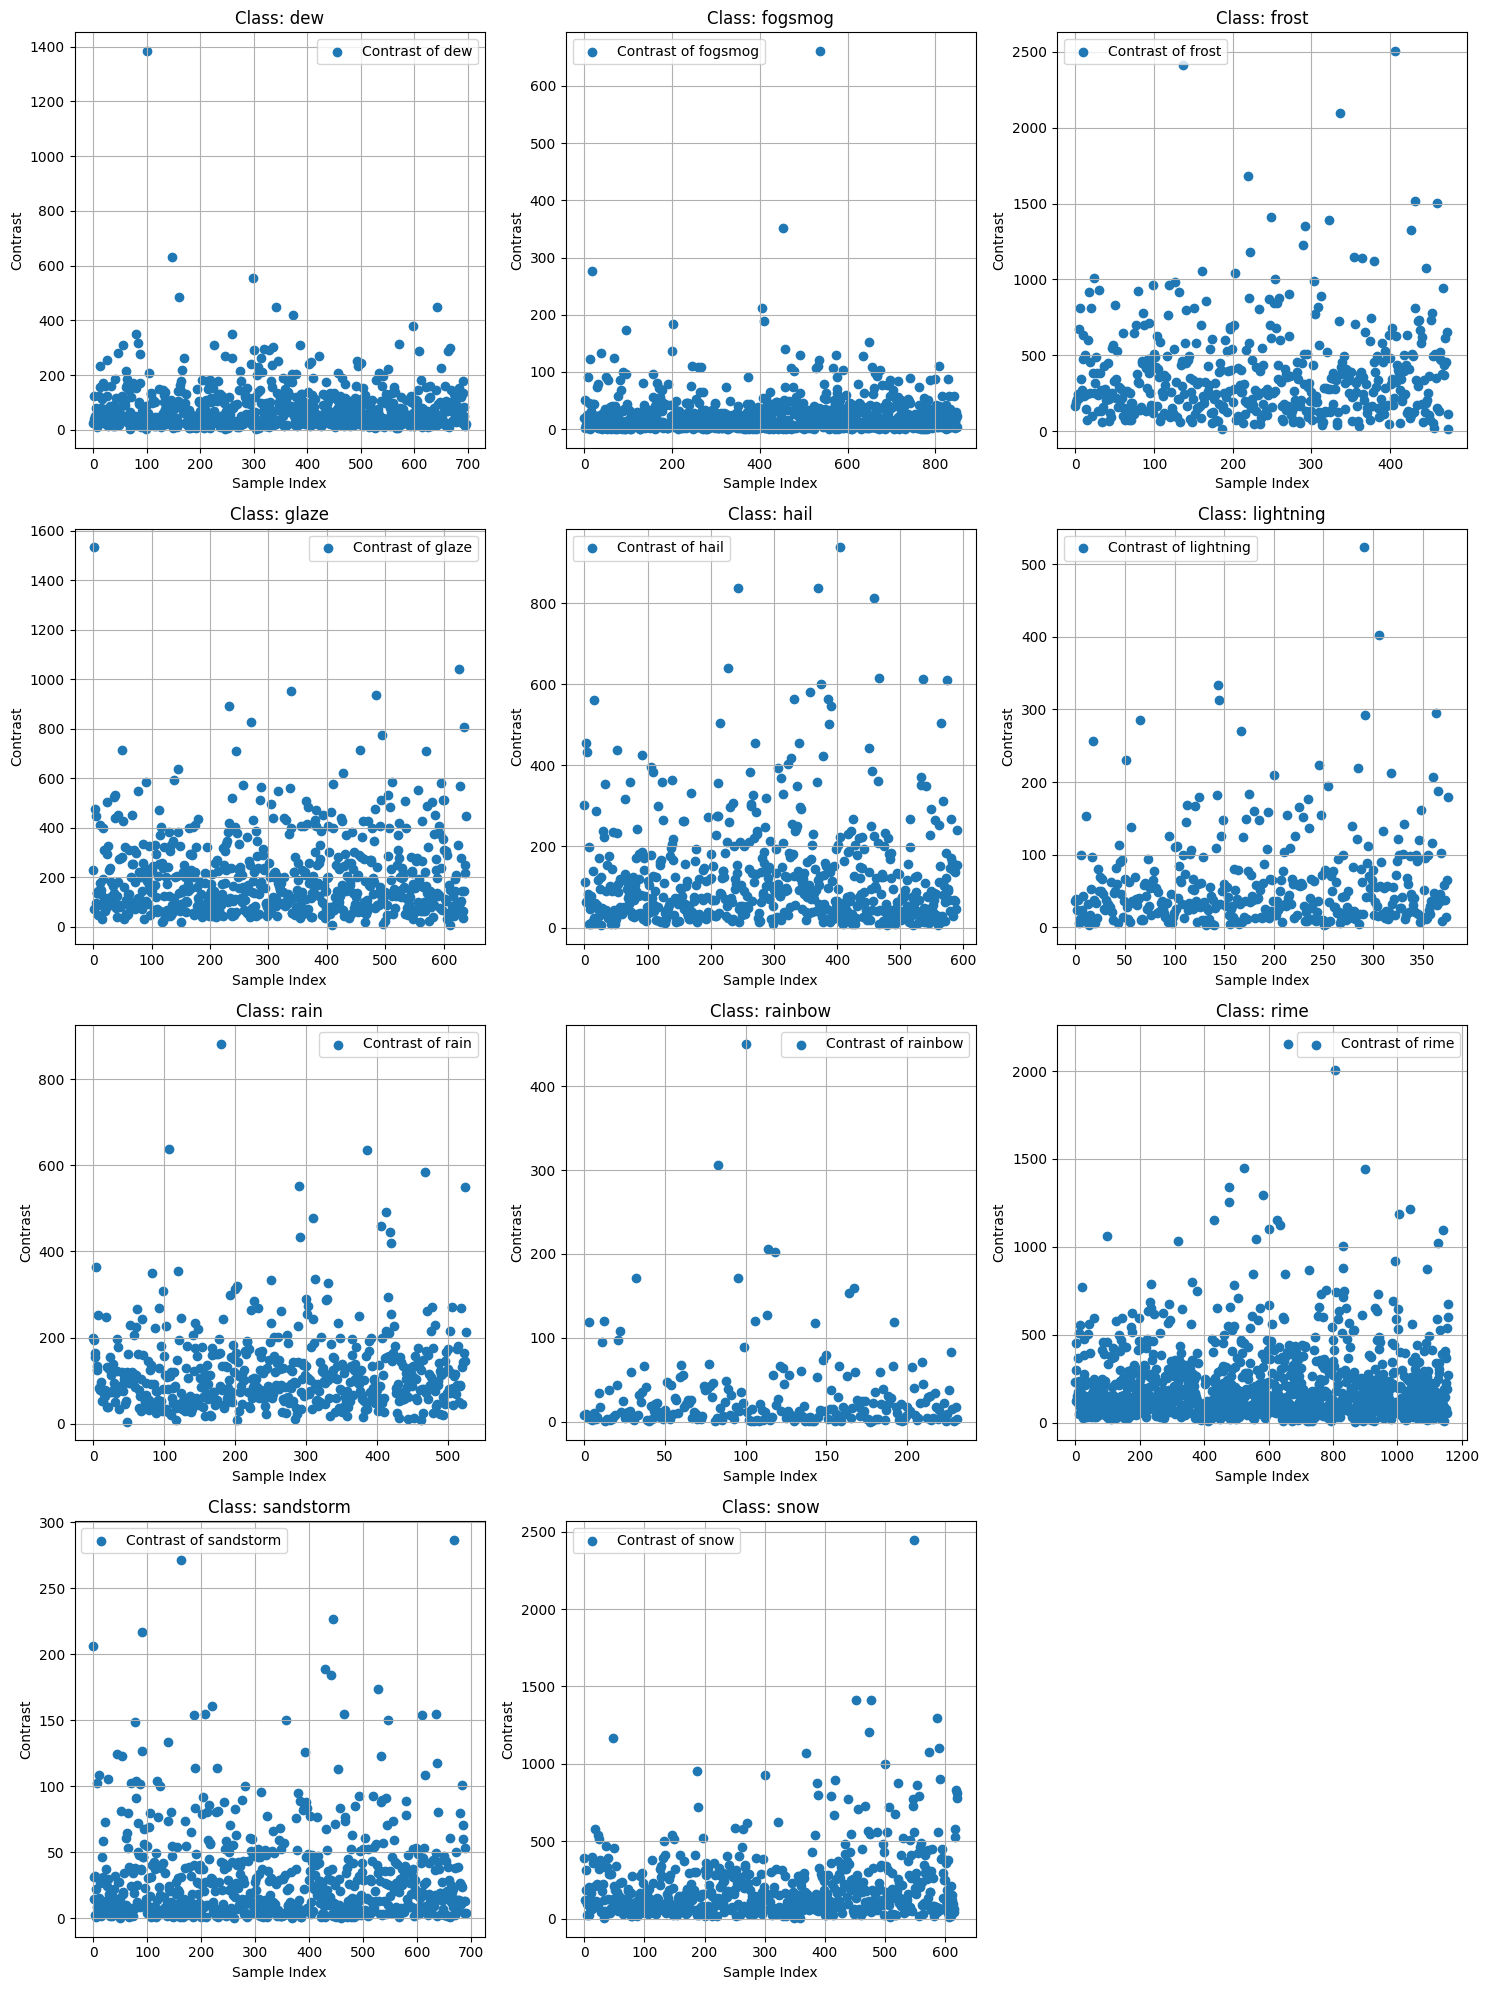

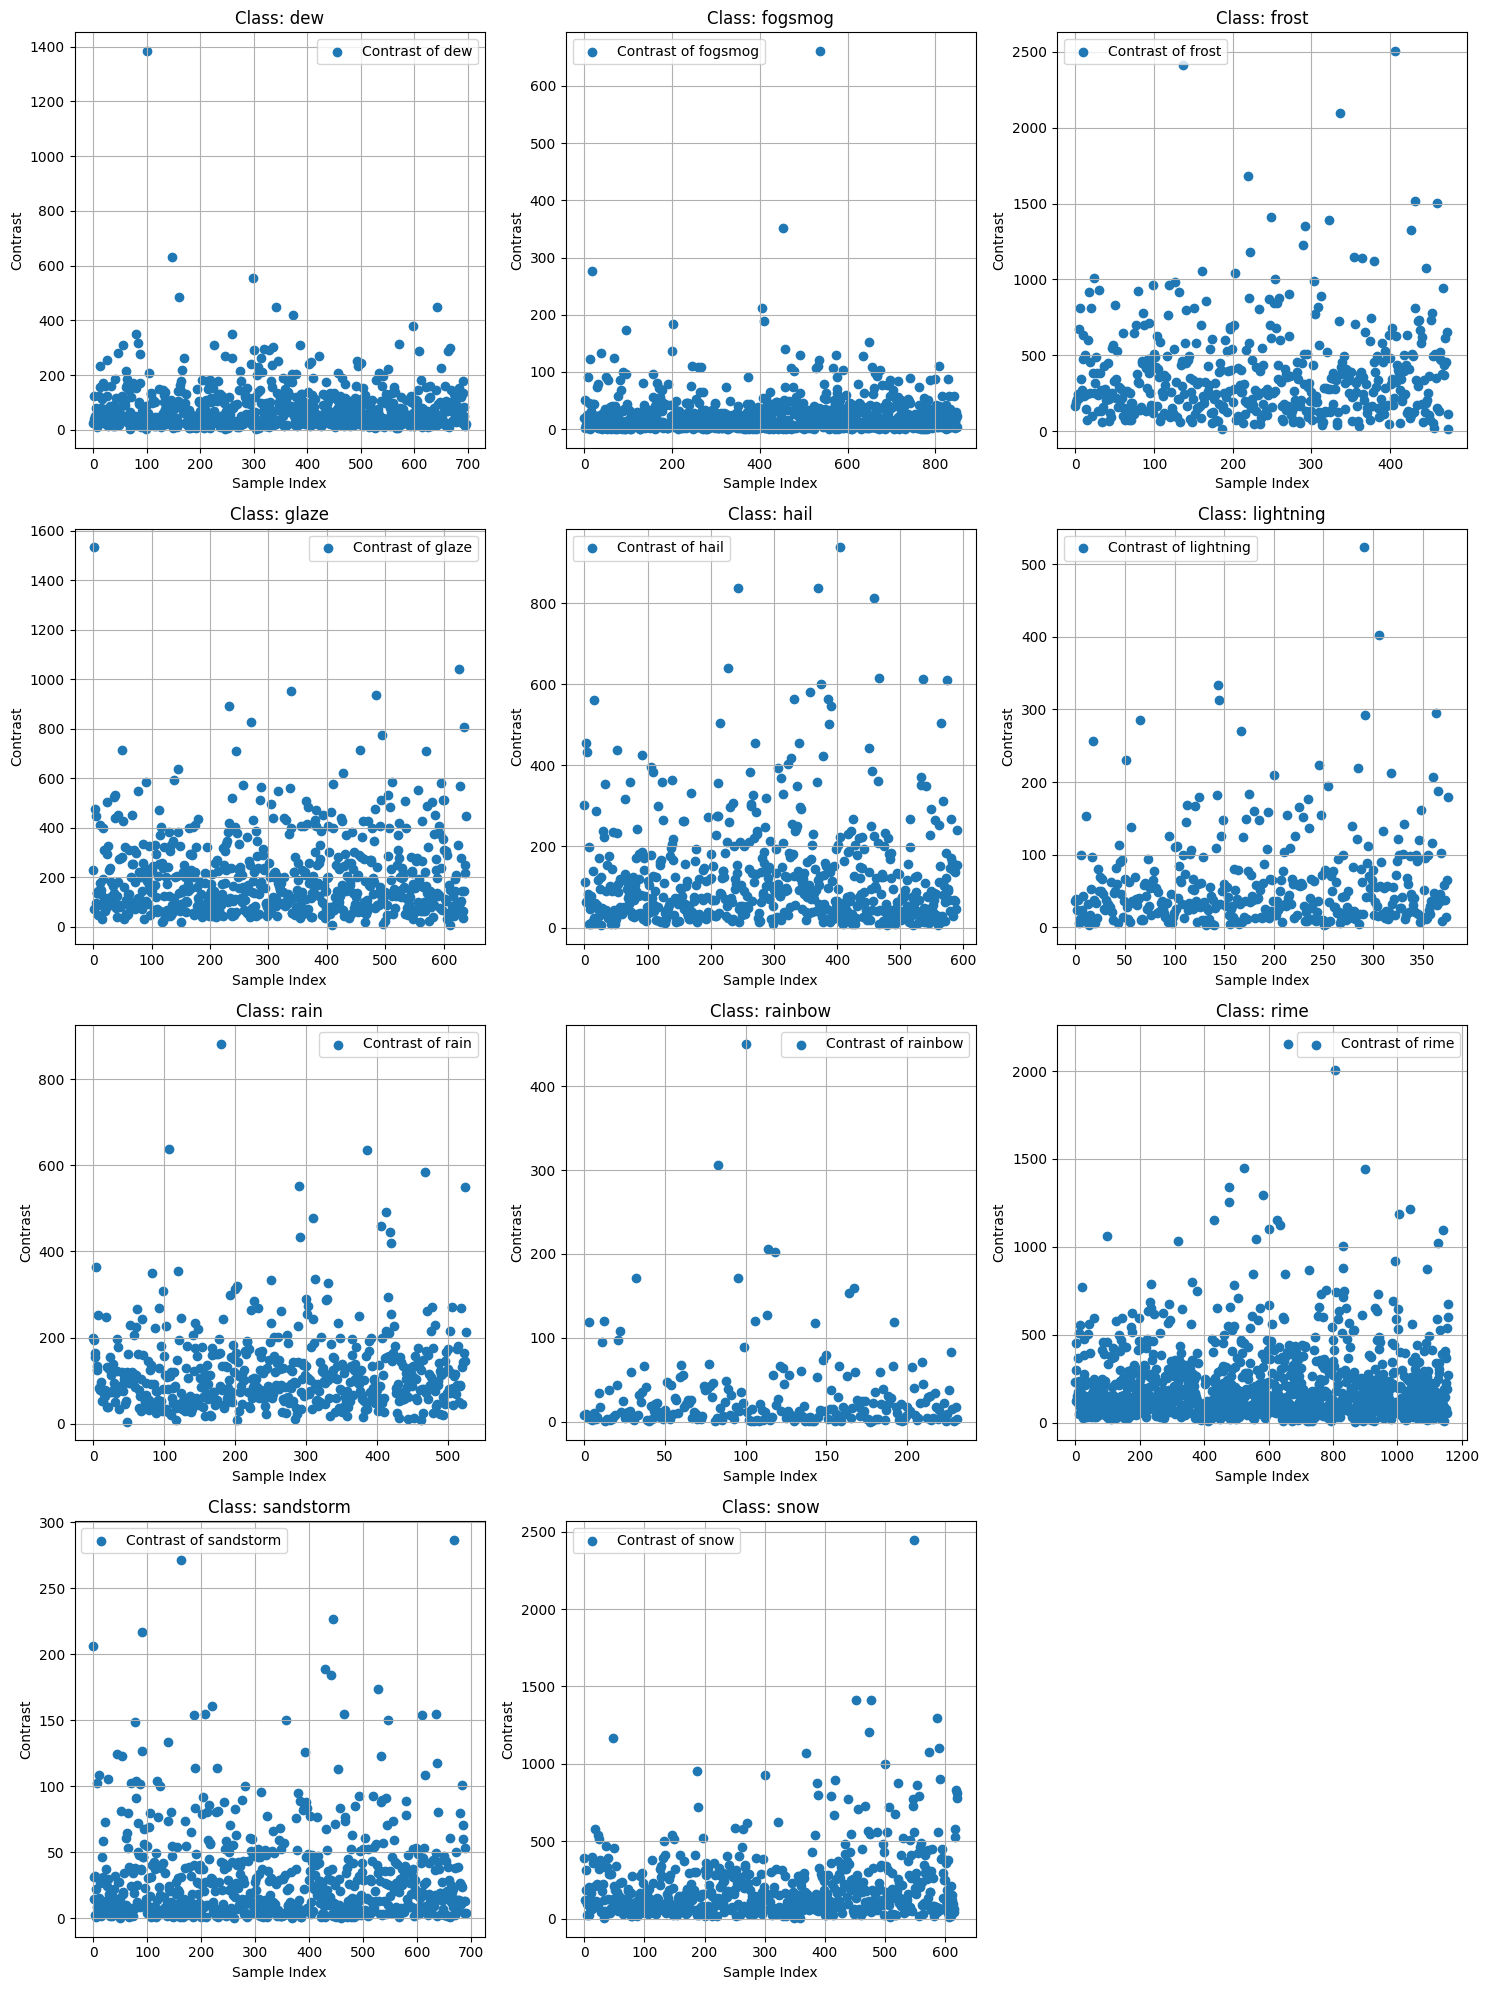

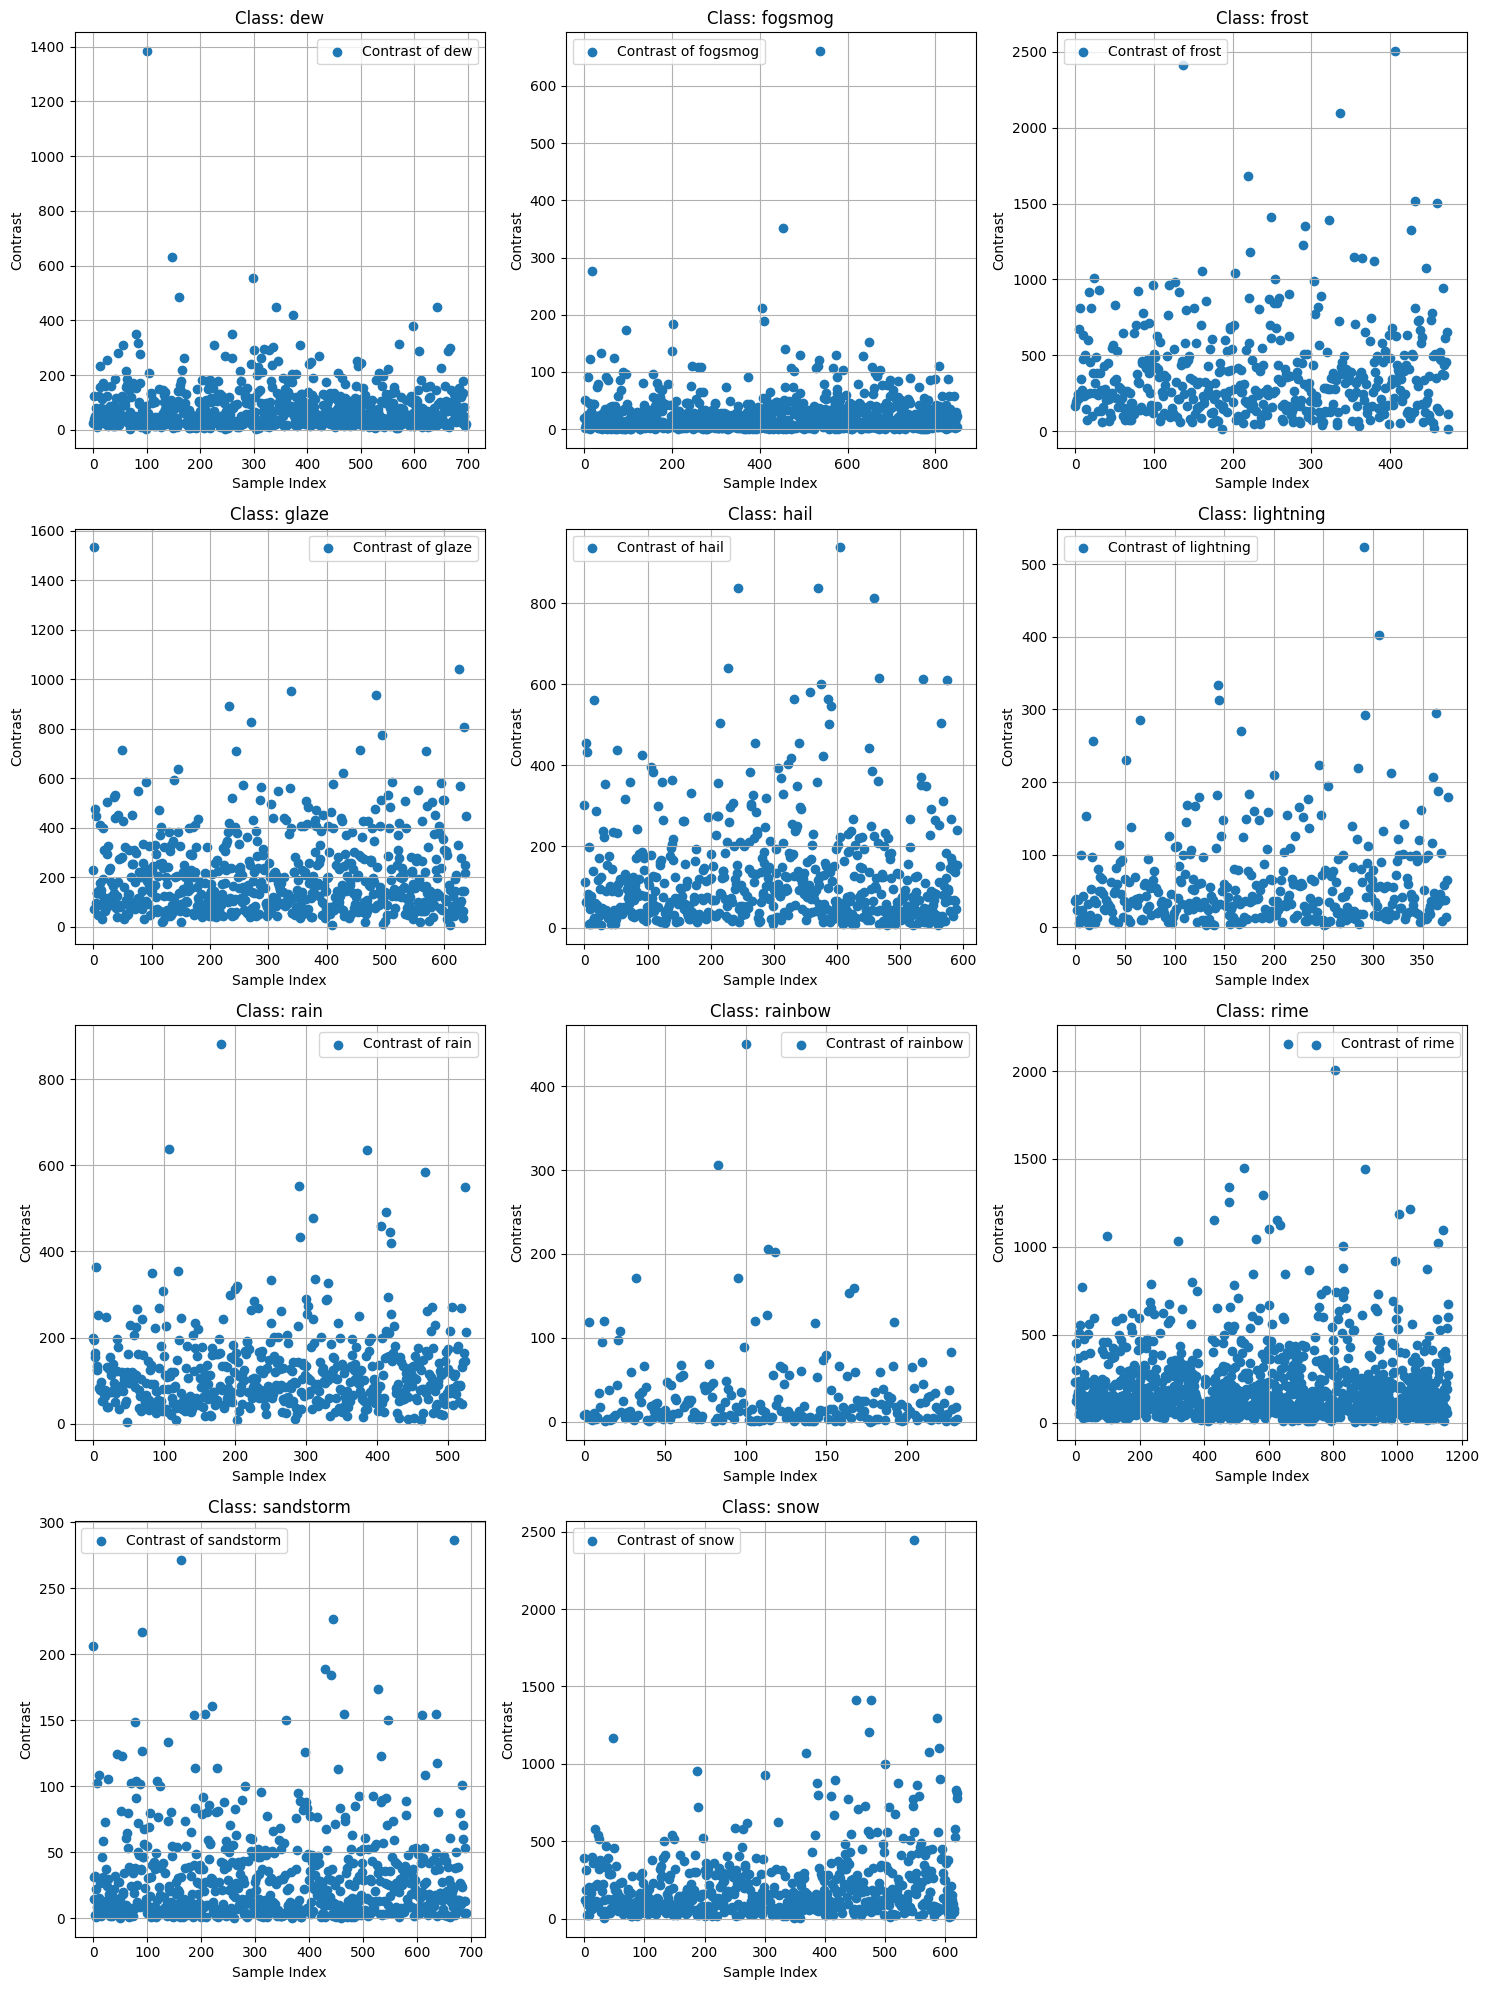

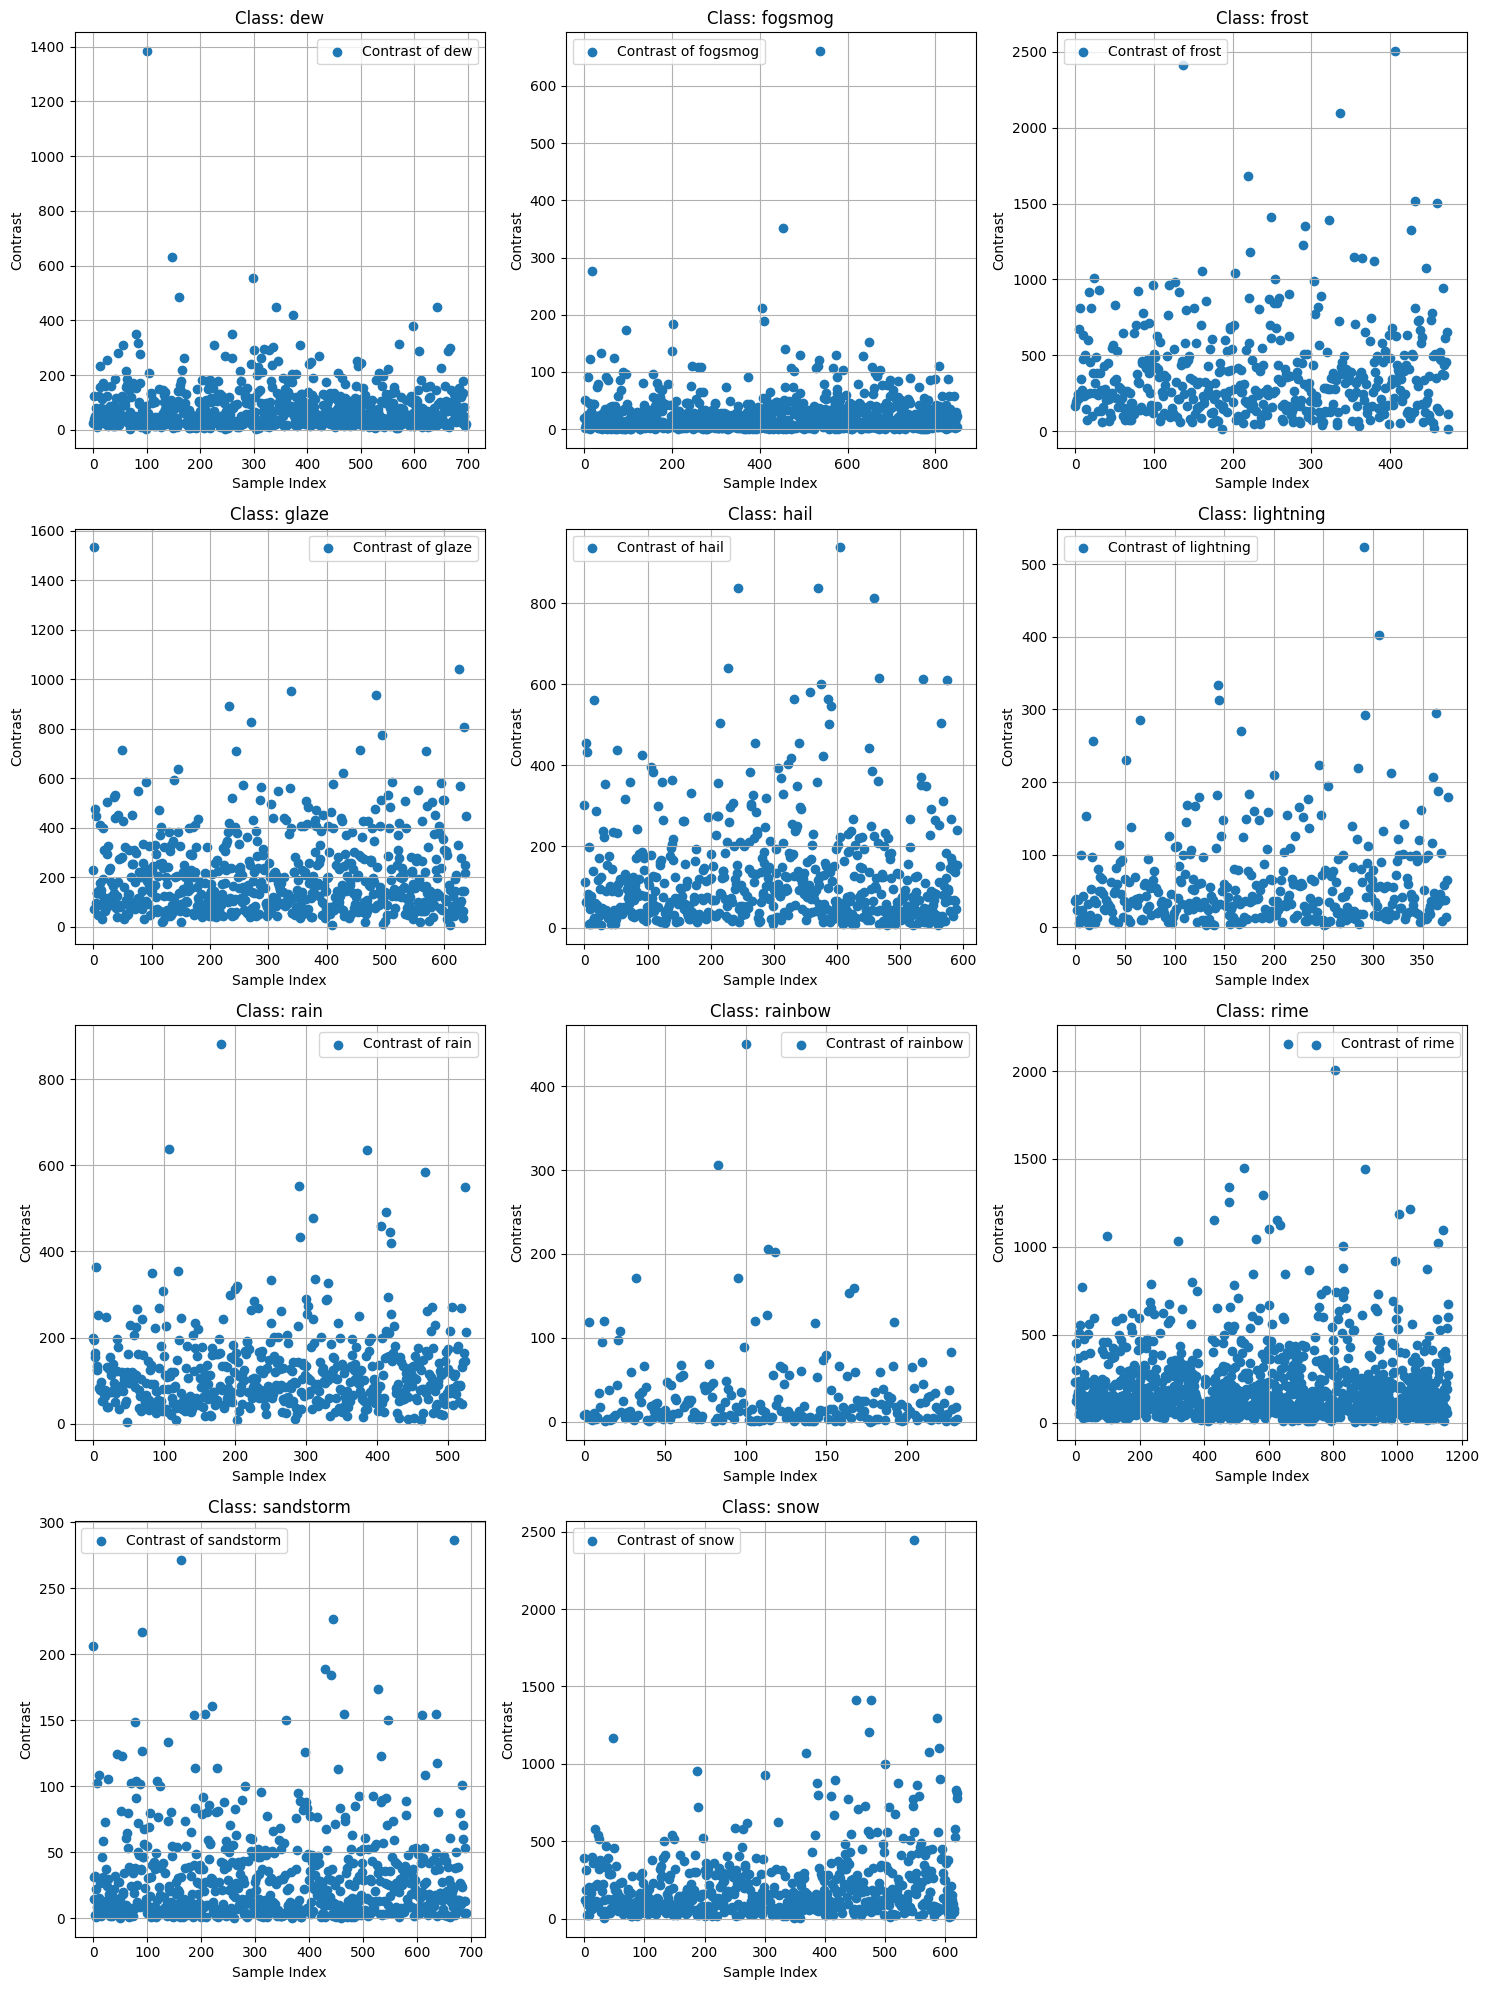

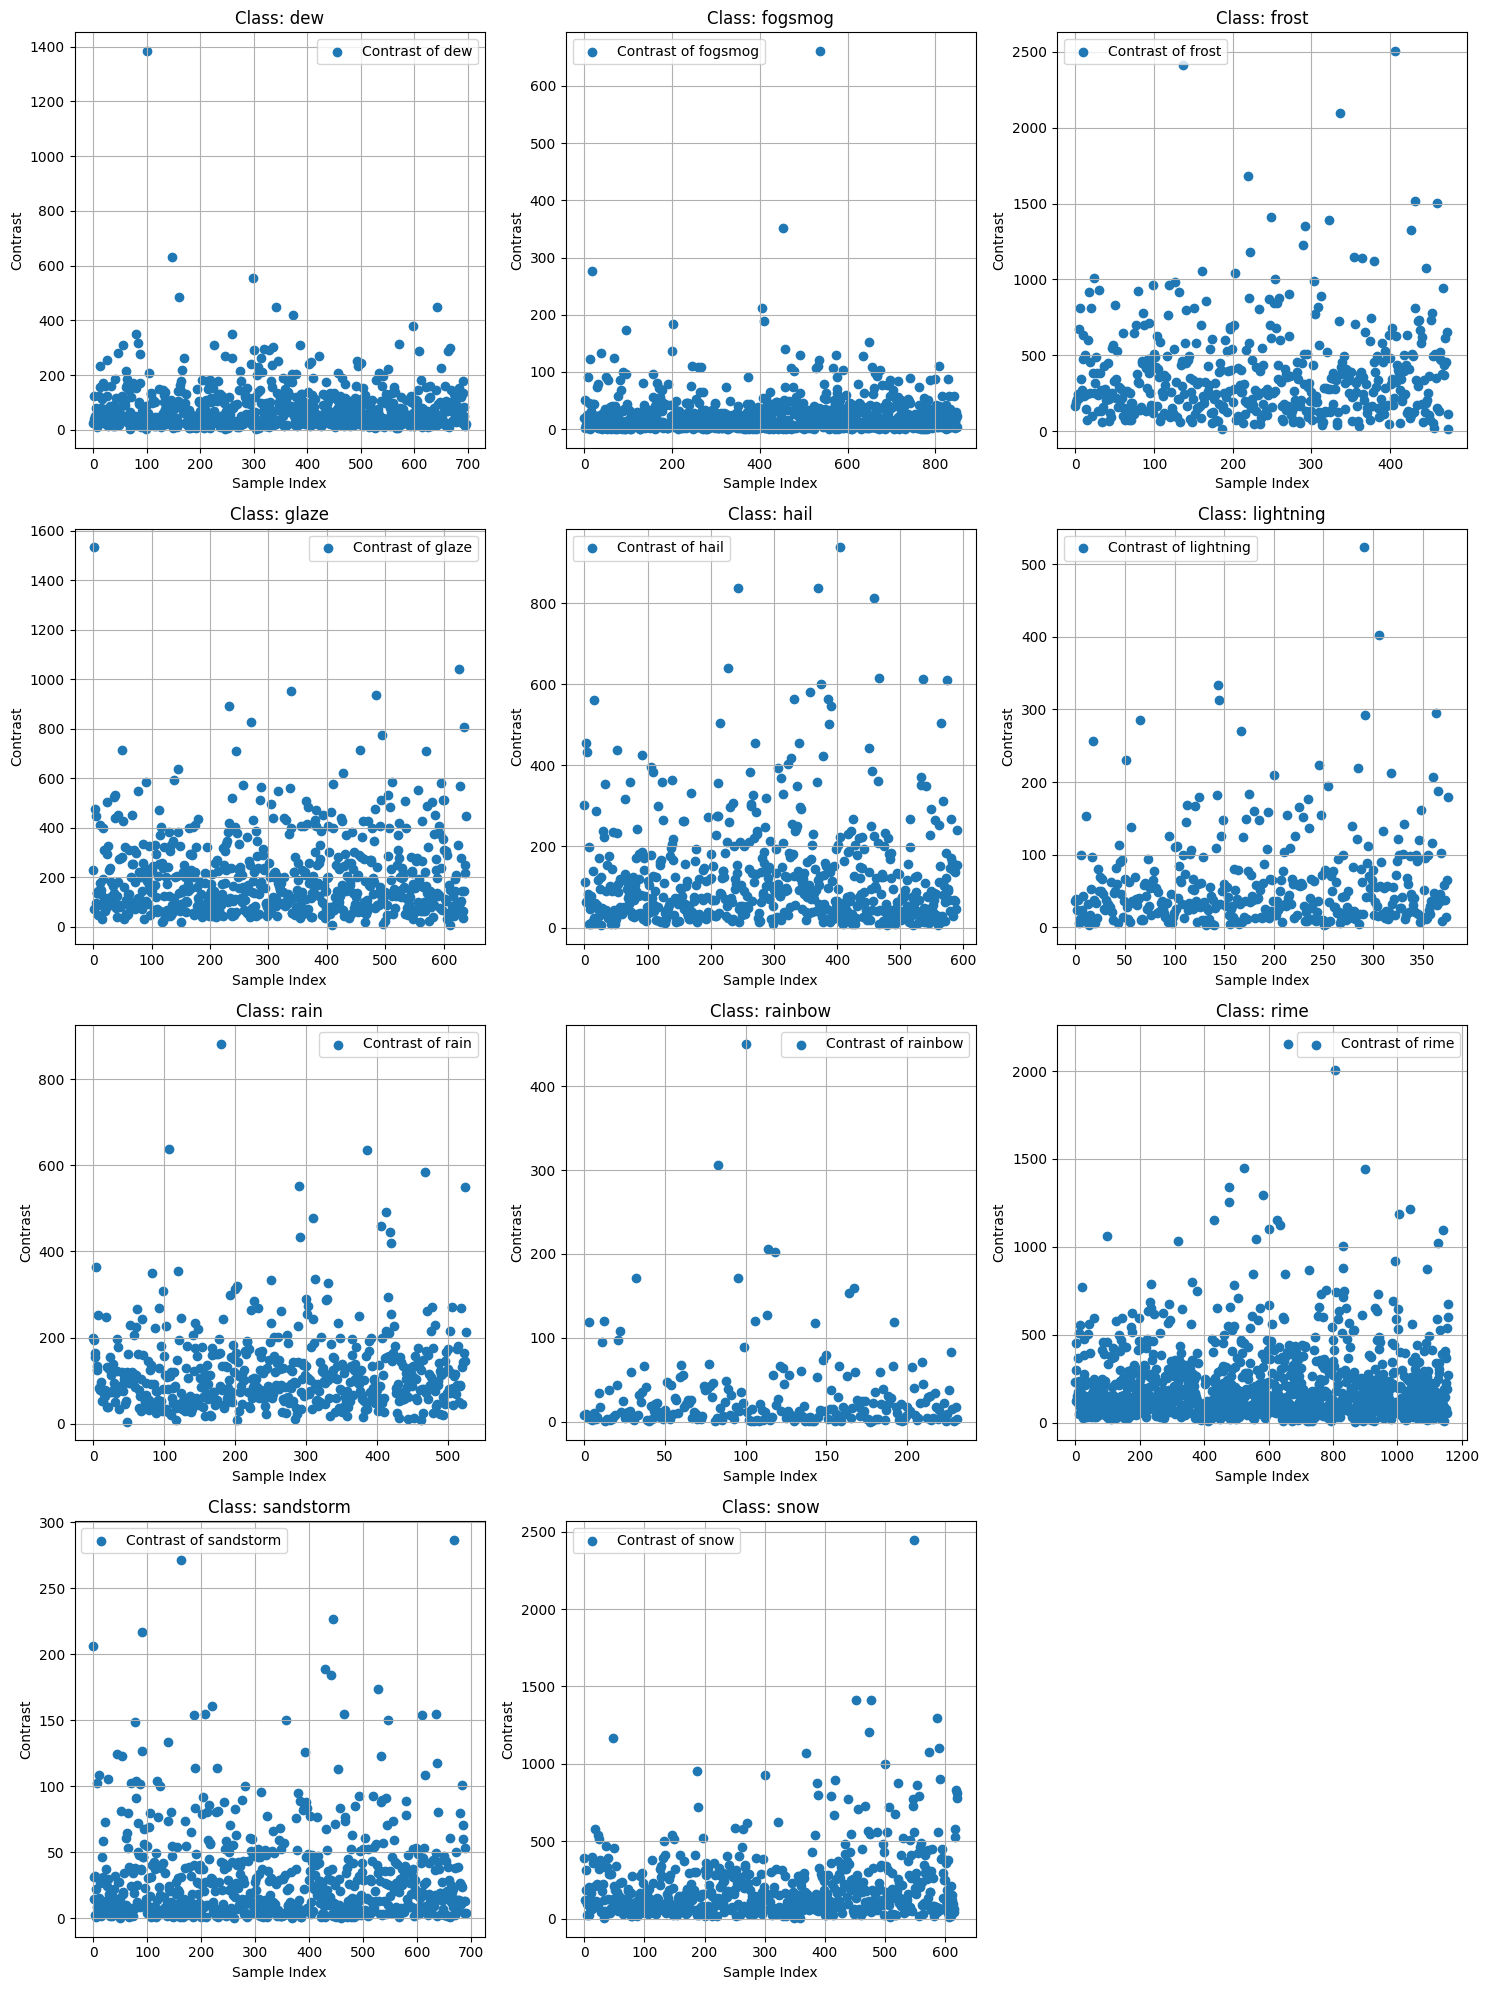

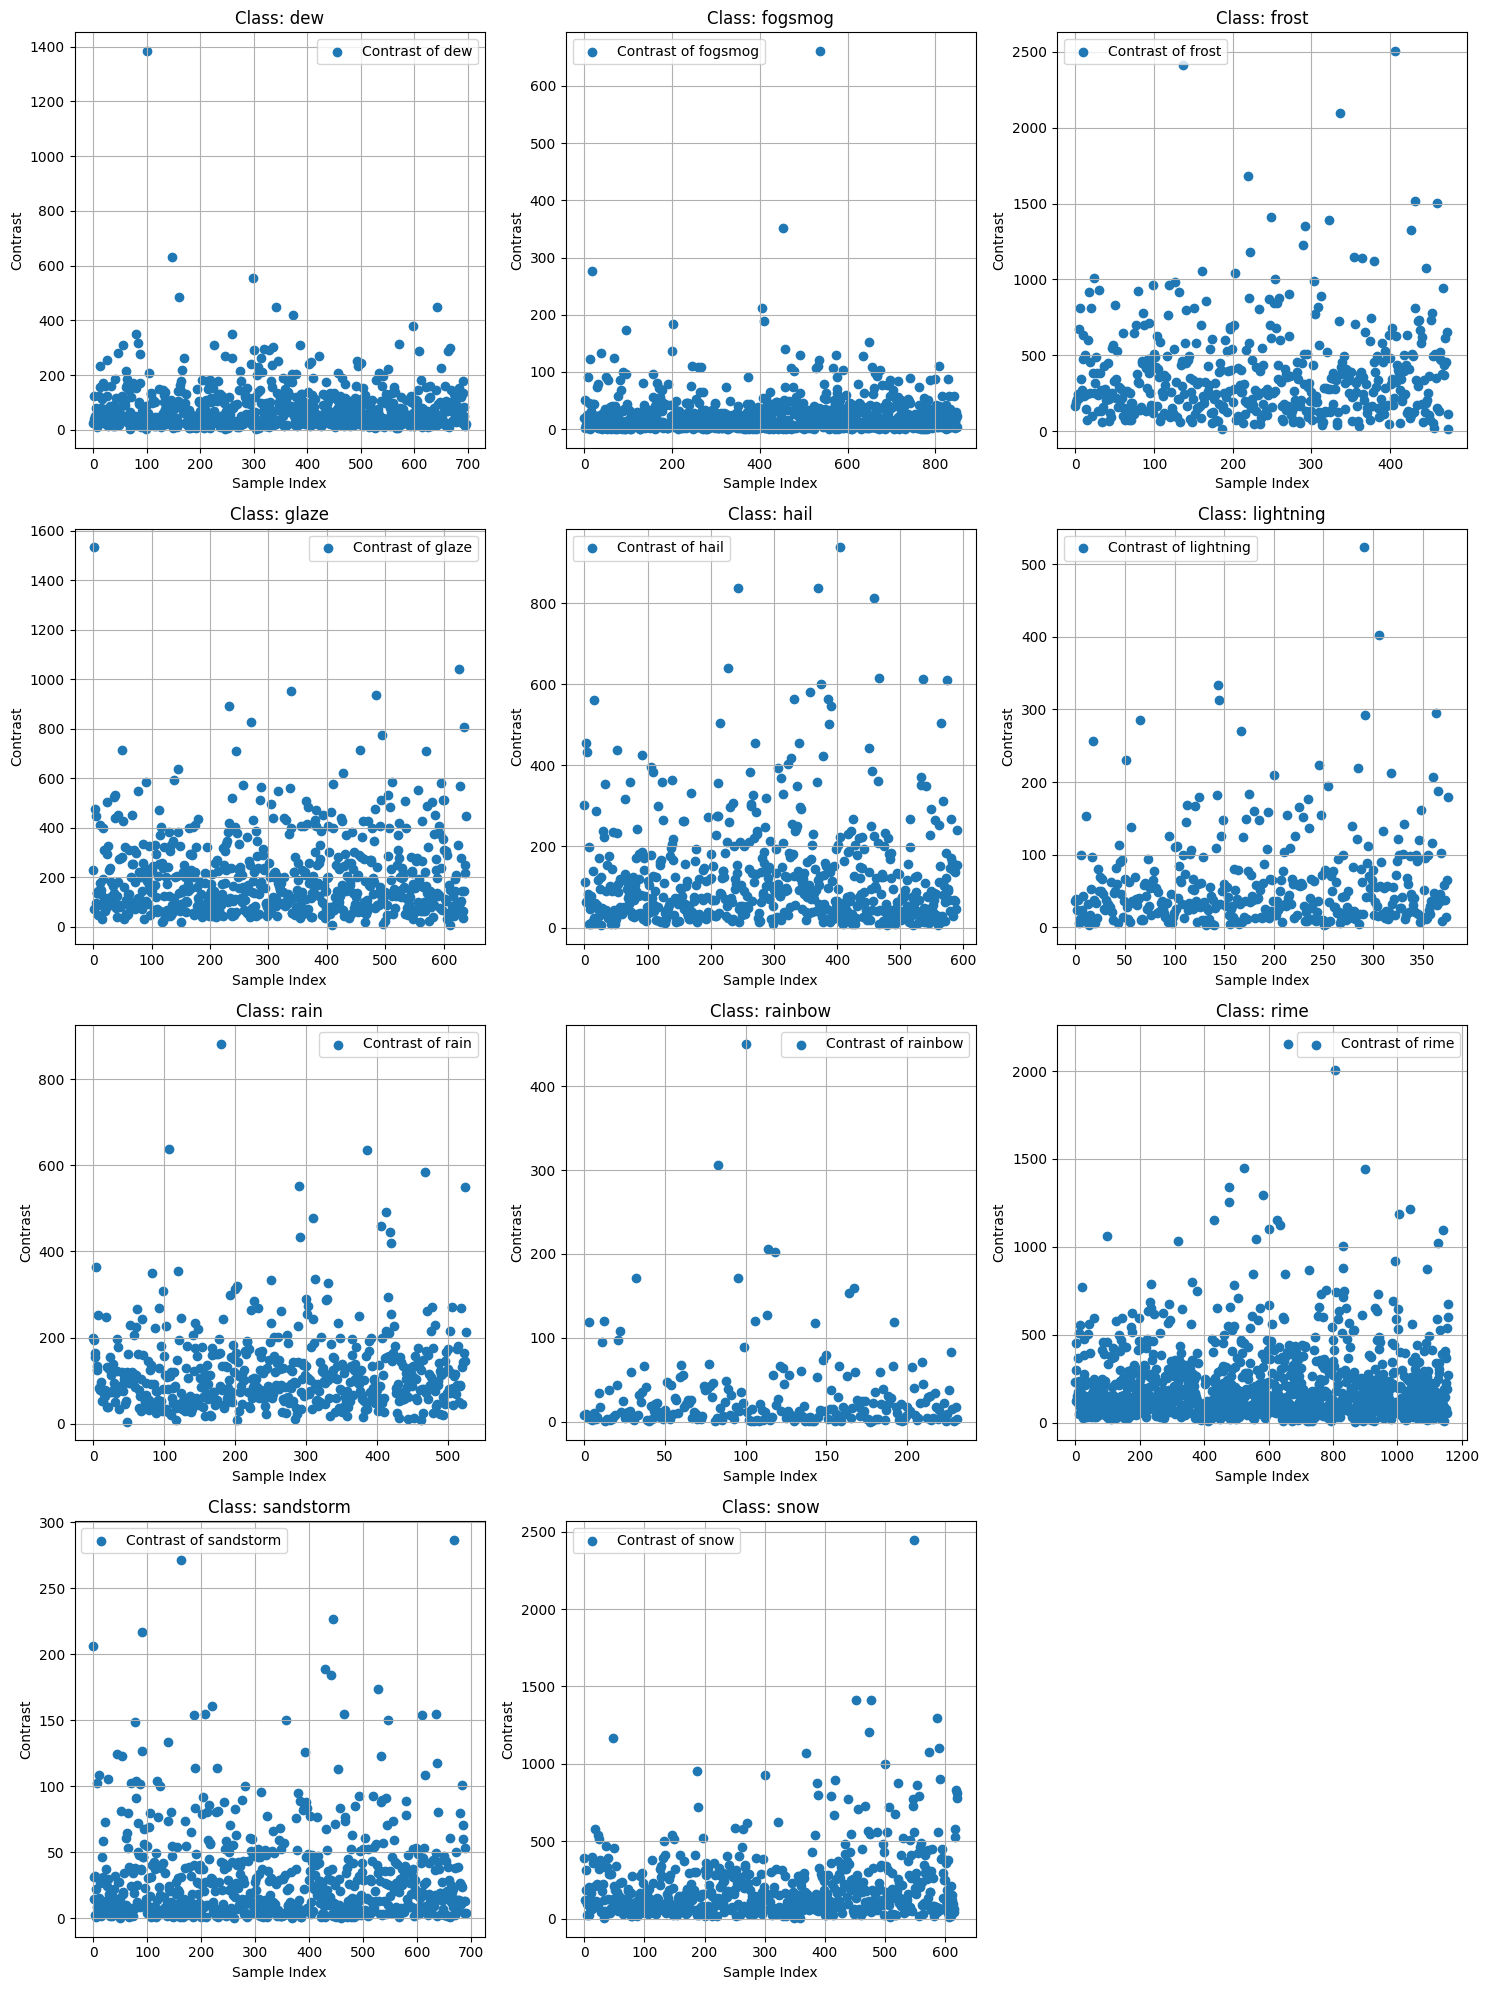

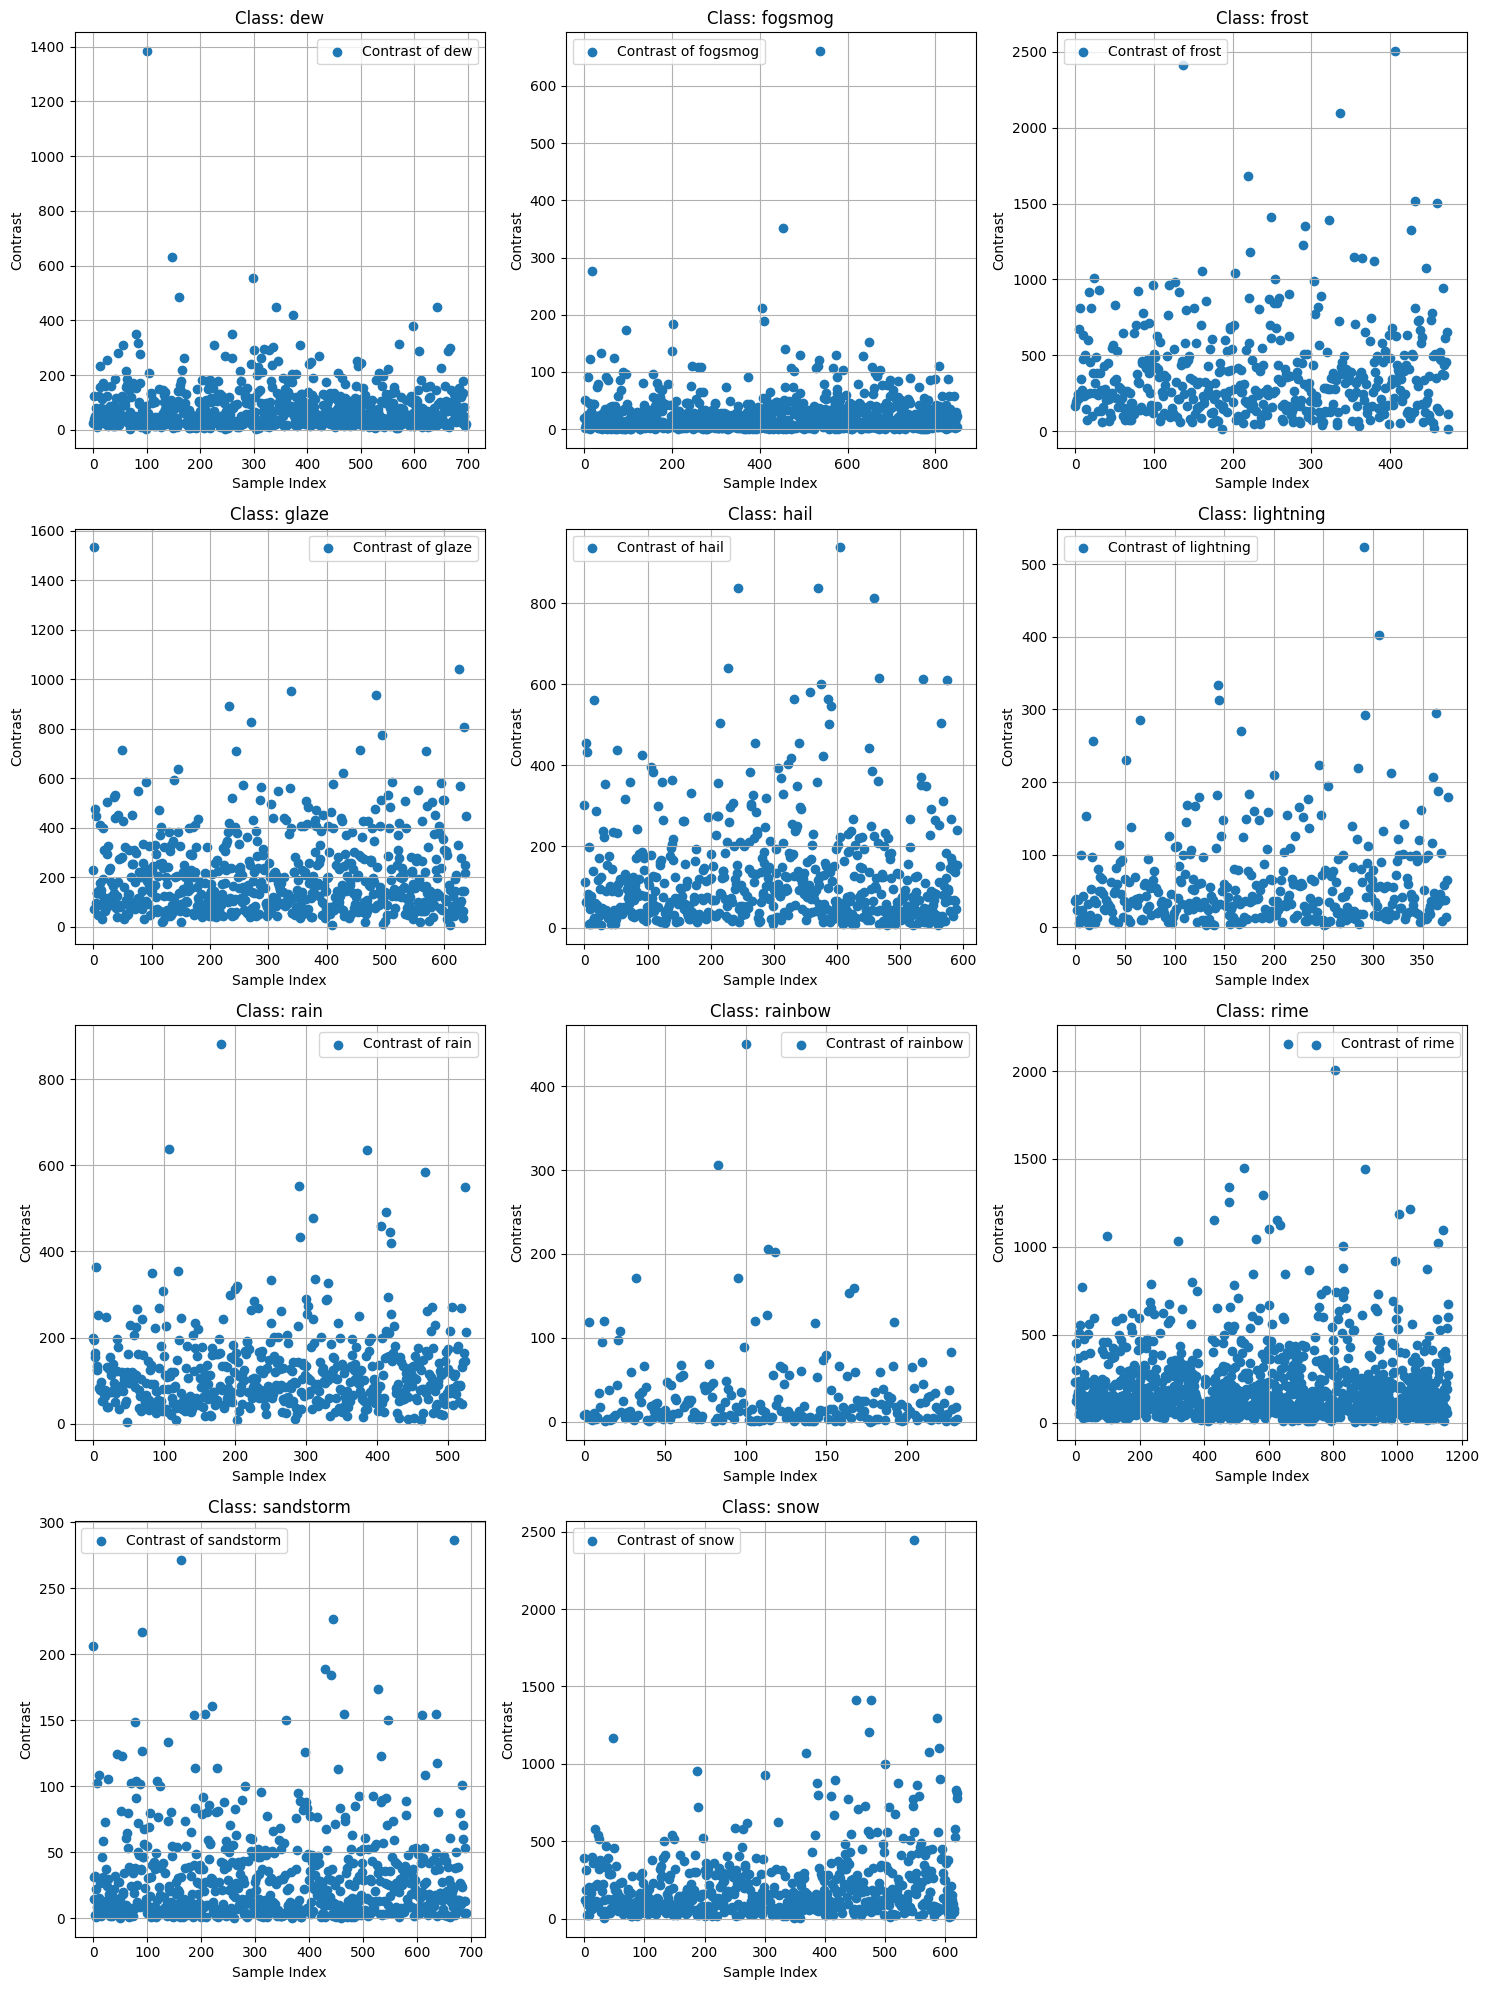

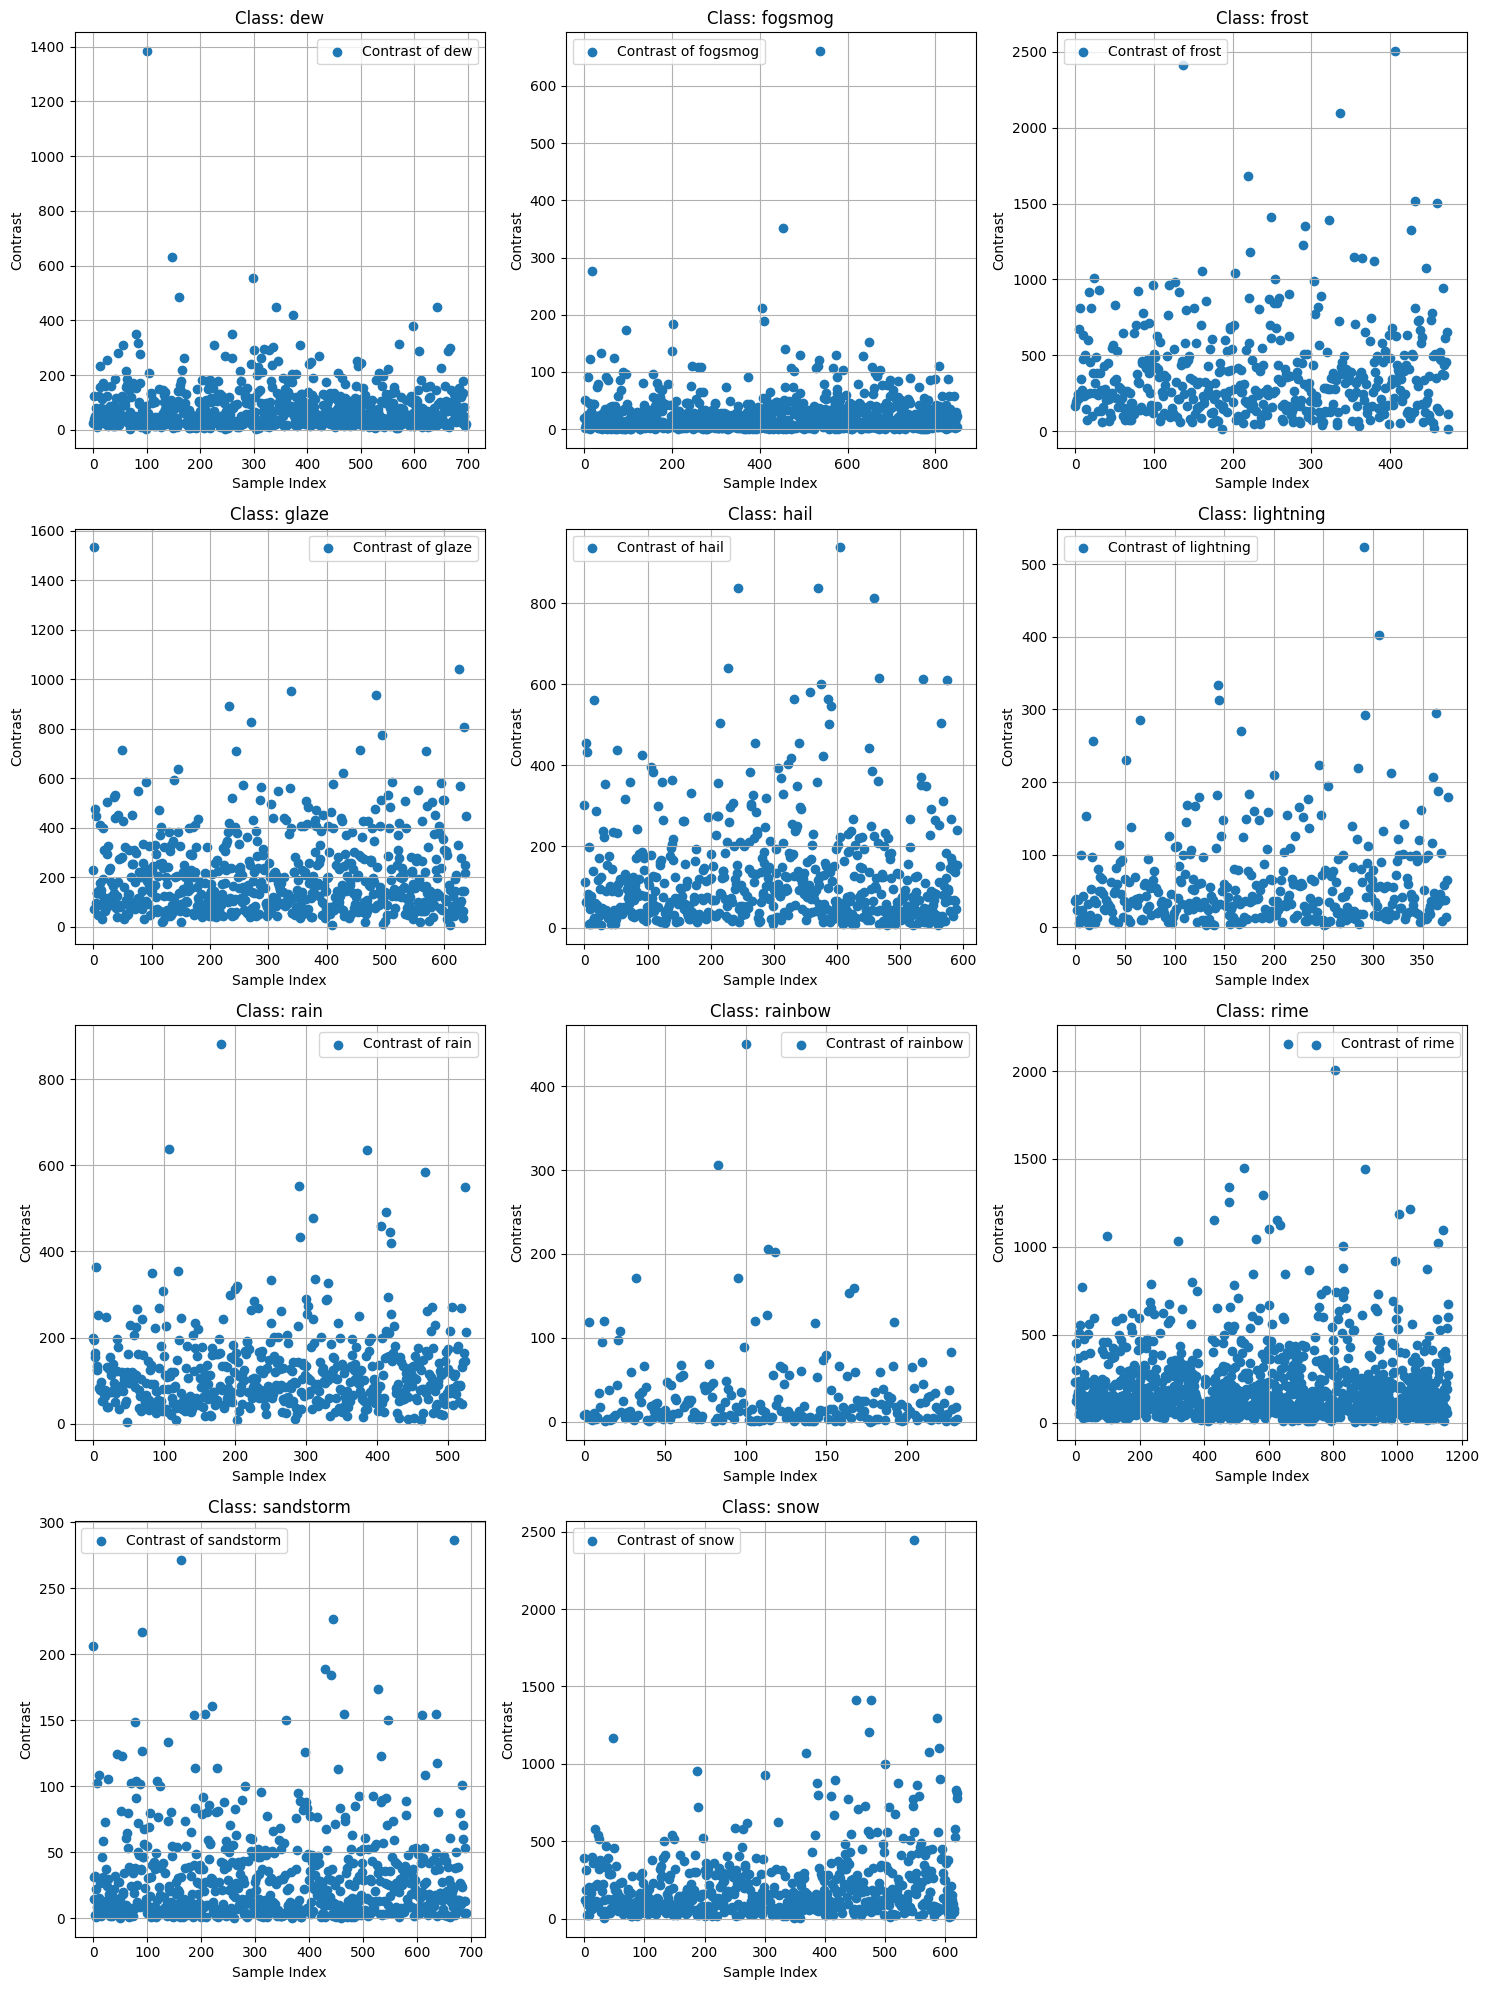

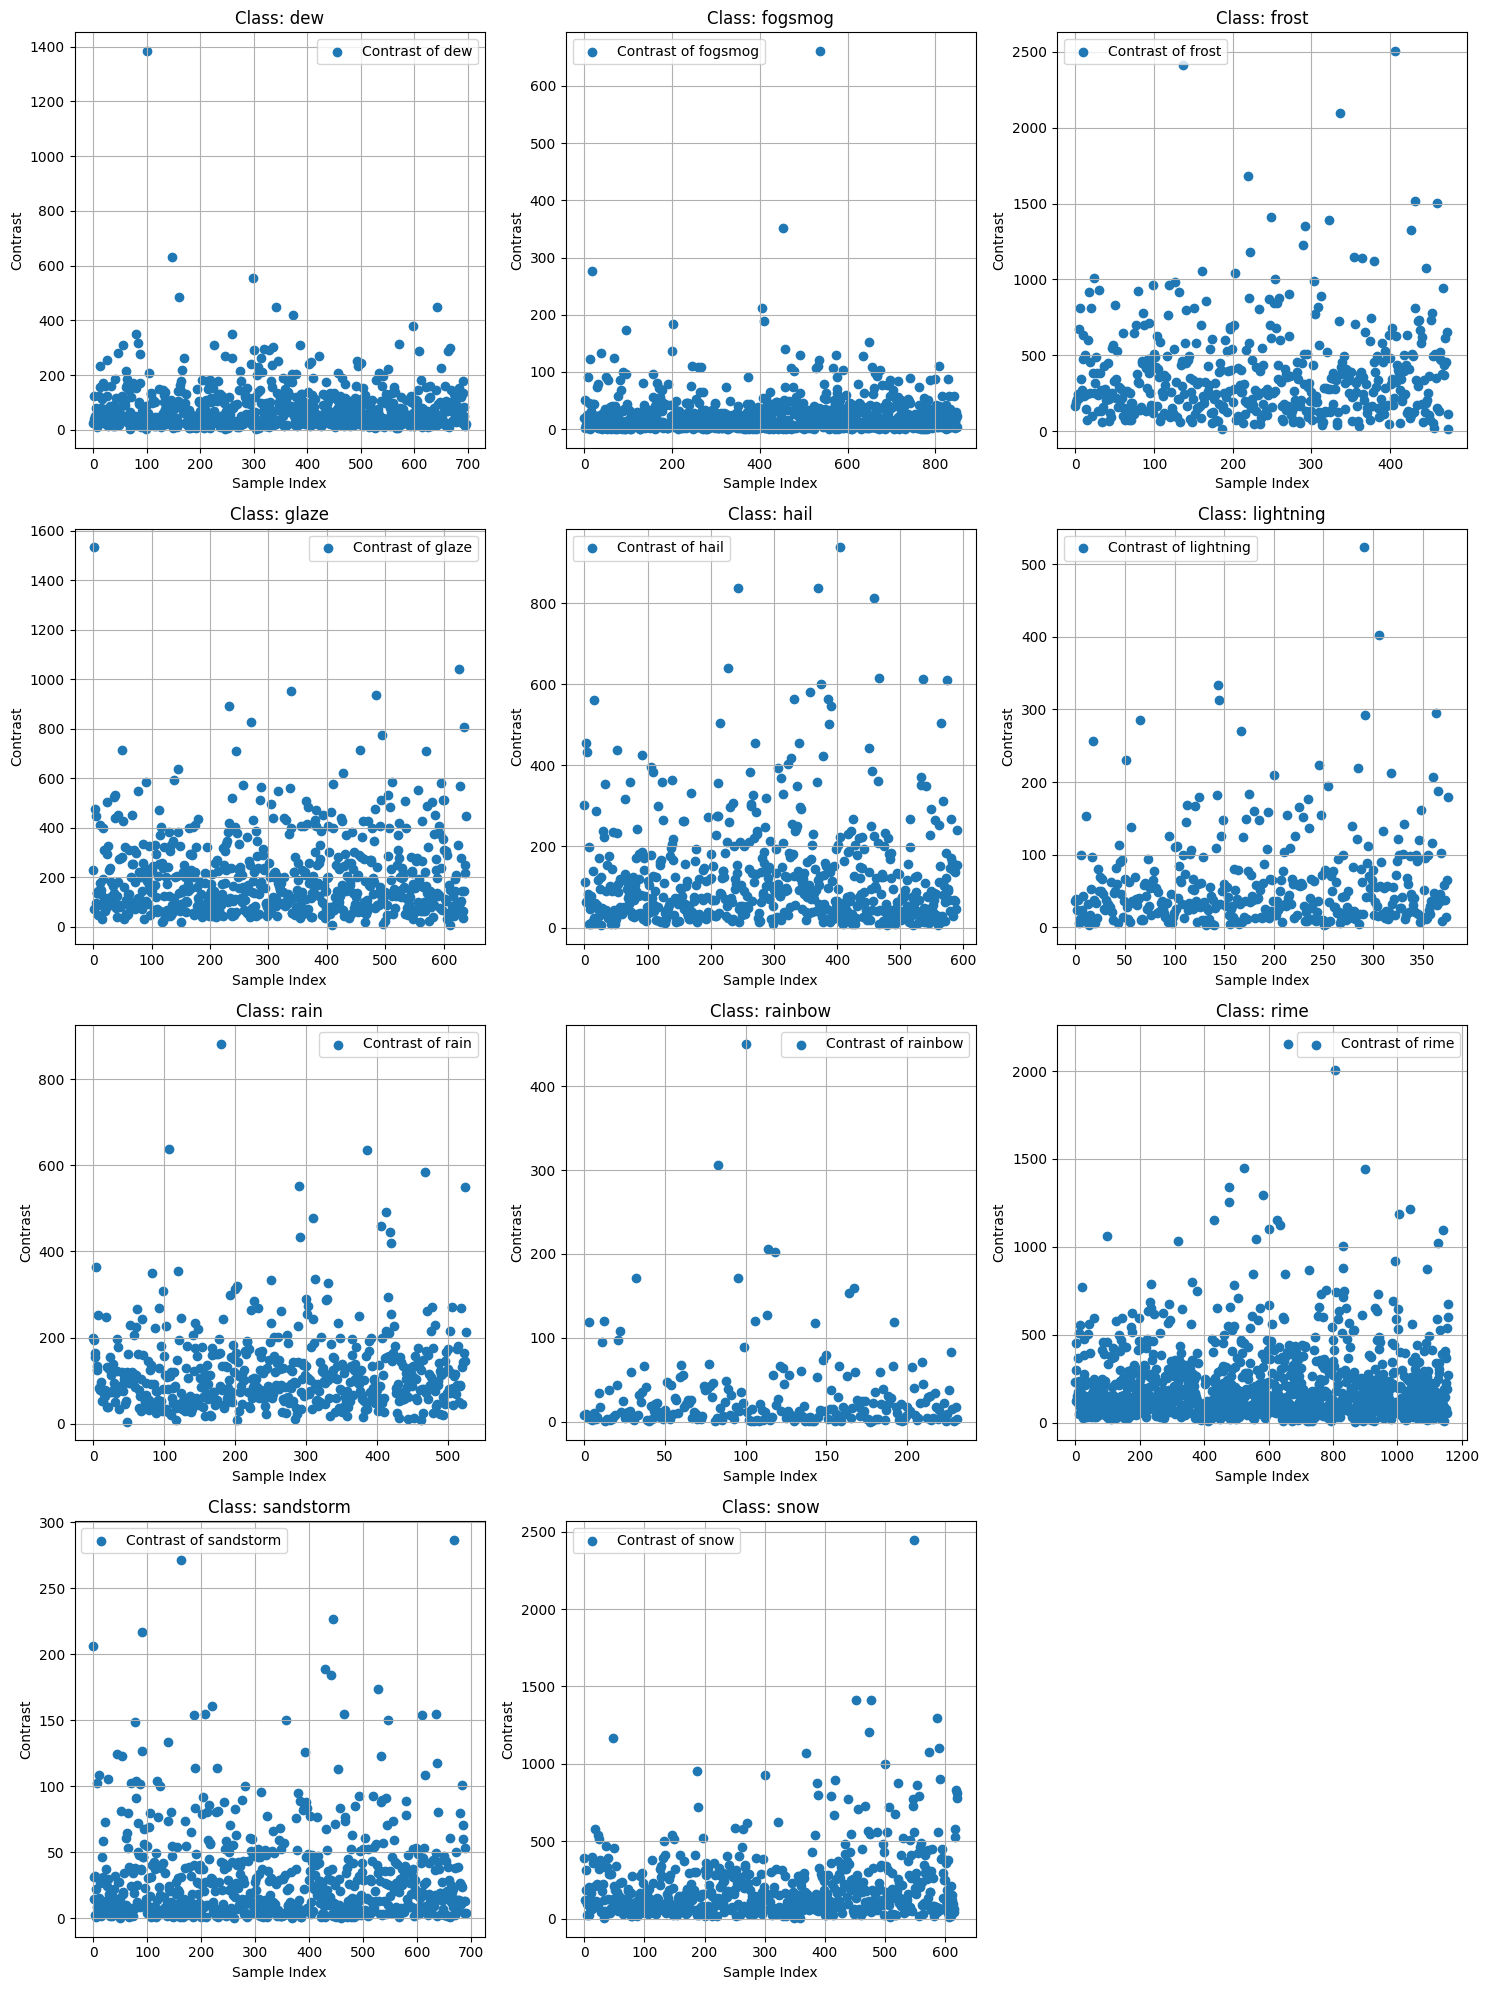

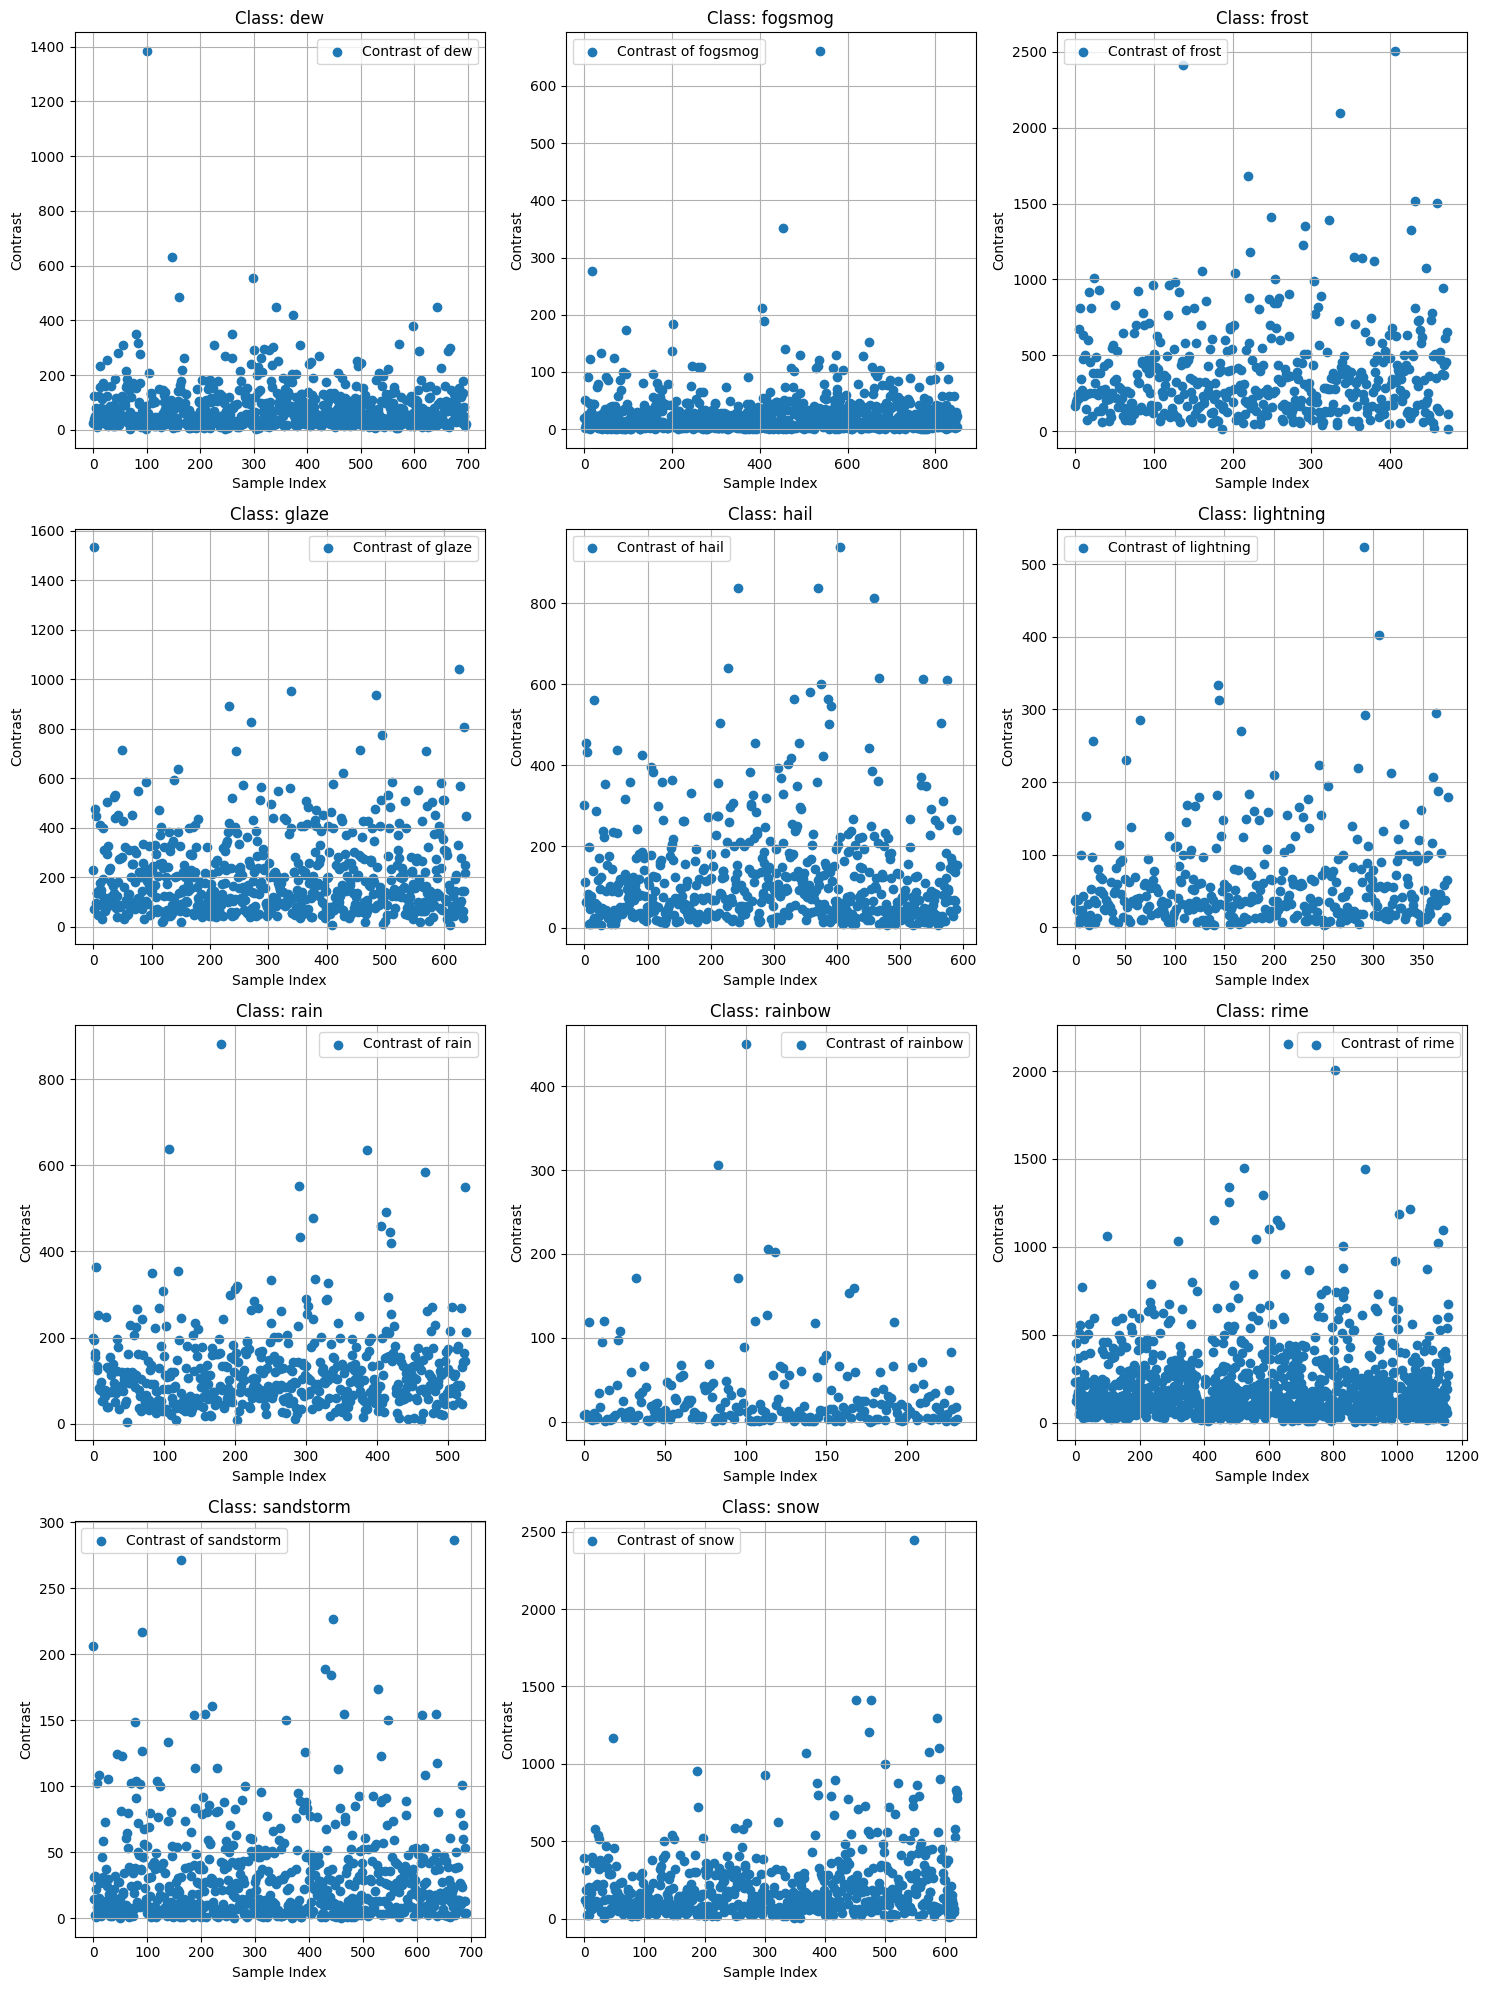

In [86]:
for class_name in class_names:
    plot_g_column(class_name)

In [99]:
def analyze_metrics(df: pd.DataFrame, metrics: list) -> pd.DataFrame:
    # DataFrame to store results
    df_metrics = pd.DataFrame()
    
    # Loop through each metric in the metrics list
    for metric in metrics:
        # Group by 'Class' and apply multiple aggregation functions
        agg_funcs = ['sum', 'min', 'max', 'mean', 'median', 'std']
        grouped = df.groupby('Class')[metric].agg(agg_funcs).reset_index()
        
        # Rename columns to include the metric name for clarity
        grouped.columns = ['Class'] + [f"{metric}_{func}" for func in agg_funcs]
        
        # If df_metrics is empty, initialize it with the grouped data
        if df_metrics.empty:
            df_metrics = grouped
        else:
            # Otherwise, merge with the existing data on 'Class'
            df_metrics = df_metrics.merge(grouped, on='Class')

    return df_metrics

In [107]:
pd.set_option("display.max_columns", None)
metrics = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation']
df_results = analyze_metrics(g, metrics)
df_results

Class   Contrast_sum  Contrast_min  Contrast_max  Contrast_mean  \
0         dew   58826.747233      3.025589   1382.805425      84.279007   
1     fogsmog   21394.926722      0.257239    660.439033      25.140924   
2       frost  179001.974518     13.580854   2503.885943     376.846262   
3       glaze  131374.322812      6.168454   1532.894543     205.593619   
4        hail   74945.159300      5.533008    937.641340     126.810760   
5   lightning   22751.702678      2.586660    523.202934      60.349344   
6        rain   64197.689014      4.812607    882.198542     122.048838   
7     rainbow    7096.451608      0.257304    450.620826      30.588153   
8        rime  250656.589236      6.847037   2155.411876     216.083267   
9   sandstorm   21908.882457      0.171401    286.607800      31.660235   
10       snow  133687.498318      6.101589   2445.863602     215.277775   

    Contrast_median  Contrast_std  Dissimilarity_sum  Dissimilarity_min  \
0         60.249251     91.393459        2598.808617           0.540274   
1         14.332689     38.250816        1283.579478           0.151702   
2        288.650681    320.402712        5243.553292           1.825274   
3        153.341029    166.614298        5125.462436           1.144233   
4         82.289900    132.195829        3489.603007           1.024798   
5         39.339355     63.893960         872.450514           0.470864   
6        100.789494     96.089750        2917.351433           1.051981   
7         14.105568     49.170801         440.616564           0.240685   
8        151.075918    216.427313        8959.346575           1.045312   
9         19.546229     36.986074        1237.204298           0.133309   
10       137.614172    231.729379        4421.057340           0.839760   

    Dissimilarity_max  Dissimilarity_mean  Dissimilarity_median  \
0           24.591942            3.723222              3.161137   
1           12.845902            1.508319              1.271163   
2           35.693566           11.039060             10.219339   
3           27.171351            8.021068              7.473165   
4           19.104483            5.904574              5.203331   
5           11.384204            2.314192              2.040098   
6           18.507358            5.546295              5.143427   
7           13.373181            1.899209              1.420879   
8           31.045927            7.723575              6.887265   
9            7.503230            1.787867              1.535537   
10          31.157335            7.119255              6.131631   

    Dissimilarity_std  Homogeneity_sum  Homogeneity_min  Homogeneity_max  \
0            2.422964       329.141440         0.058734         0.898184   
1            1.014639       581.077250         0.305568         0.951860   
2            5.533455       105.732152         0.048919         0.678963   
3            3.912052       181.385805         0.057518         0.871354   
4            3.573455       185.285345         0.057239         0.697005   
5            1.330412       239.182065         0.211174         0.890974   
6            2.367826       170.057850         0.093644         0.764978   
7            1.557973       146.351418         0.122200         0.901164   
8            4.069130       393.777033         0.067396         0.782779   
9            1.116560       444.266664         0.197480         0.936846   
10           4.325635       225.682063         0.063237         0.814264   

    Homogeneity_mean  Homogeneity_median  Homogeneity_std  Energy_sum  \
0           0.471549            0.469966         0.161767   40.006553   
1           0.682817            0.695052         0.112247   63.399355   
2           0.222594            0.186468         0.129561   13.544740   
3           0.283859            0.255532         0.146991   23.661162   
4           0.313512            0.292297         0.140977   18.092387   
5           0.634435            0.640589         0

# Comprehensive Analysis of Textural Features Across All Weather Classes

## Overview
We analyze key textural metrics for weather-related images: Contrast, Dissimilarity, Homogeneity, Energy, and Correlation. The statistical properties of these metrics (sum, min, max, mean, median, and std) help to better understand each weather class's textural characteristics.

## Detailed Metrics Analysis per Class

### Dew
- **General Features**: Moderate contrast and low dissimilarity suggest smoother textures.
- **Texture Consistency**: High median homogeneity and energy indicate a consistent and uniform texture throughout the images.

### Fogsmog
- **Simplicity in Texture**: Low maximum contrast and dissimilarity point to less texture complexity, typical of foggy conditions.
- **Uniformity**: Very high correlation with minimal standard deviation reflects uniform texture patterns across images.

### Frost
- **High Complexity**: Very high max contrast and dissimilarity highlight the complex and granular nature of frost textures.
- **Varied Texture**: Lower mean homogeneity and higher std in energy suggest varied textures within the class.

### Glaze
- **Sharp Textures**: High max contrast indicative of sharp, icy textures.
- **Moderate Variability**: Mid-range homogeneity and energy values with moderate variability show a mix of smooth and textured areas.

### Hail
- **Distinct Features**: Noticeable high max contrast but lower than frost or snow, suitable for detecting solid precipitation like hail.
- **Texture Depth**: Dissimilarity and homogeneity values suggest textured but not overly complex surfaces.

### Lightning
- **Dynamic Range**: High max contrast values appropriate for capturing the dramatic changes in light typical of lightning.
- **High Energy**: Indicates some uniform patterns possibly due to the rapid changes in lighting conditions.

### Rain
- **Moderate Textures**: Mid-range values in contrast and dissimilarity, typical for rain which may not alter texture as dramatically as hail or snow.
- **Consistency**: Relatively consistent texture indicated by low std in homogeneity and correlation.

### Rainbow
- **Low Impact on Texture**: Very low max contrast and dissimilarity values, as rainbows typically affect color more than texture.
- **High Correlation**: High mean and low std in correlation indicate consistent textural patterns where rainbows appear.

### Rime
- **Extreme Texture Complexity**: Highest max contrast and very high dissimilarity indicating very complex textures.
- **Consistency and Uniformity**: High energy sum and low std in homogeneity signify uniform but complex patterns.

### Sandstorm
- **Rough Textures**: Noticeably rough textures shown by higher dissimilarity and lower homogeneity.
- **Dynamic Texture Variability**: Moderate std in energy and correlation indicates variability in texture during sandstorms.

### Snow
- **Most Complex**: Highest max values in contrast and dissimilarity, suggesting highly complex and varied textures.
- **Diverse Textures**: High std values in almost all metrics reflect the diversity in texture present in snow scenes.

## Conclusions
- **Impact on CNN Design**: Each class shows unique textural signatures that should inform the design and training of CNN models. Classes with high texture variability (like snow and rime) may require more complex feature extraction techniques.
- **Feature Selection for CNNs**: Understanding these metrics aids in selecting relevant features for CNN architectures, potentially improving model accuracy and robustness in weather classification tasks.
- **Targeted Data Augmentation**: Insights from the texture analysis could guide targeted data augmentation strategies, enhancing model training by emphasizing critical textural differences between classes.

This detailed textural analysis provides essential insights for optimizing CNN models in weather classification, ensuring models are sensitive to the nuanced differences across diverse weather phenomena.


In [18]:
g.describe()

Contrast  Dissimilarity  Homogeneity       Energy  Correlation
count  6862.000000    6862.000000  6862.000000  6862.000000  6862.000000
mean    140.752251       5.332124     0.437473     0.051690     0.969522
std     189.275839       4.363547     0.207979     0.044787     0.036442
min       0.171401       0.133309     0.048919     0.007302     0.585670
25%      28.593515       1.964533     0.266032     0.024162     0.960530
50%      78.084648       4.142425     0.415784     0.040621     0.981223
75%     174.909515       7.389499     0.611204     0.064710     0.992430
max    2503.885943      35.693566     0.951860     0.867199     0.999964

In [46]:
# edge detection of one random image of every class
def apply_canny_edge_detection():
    one_rand_img = dict()
    for key, images in image_classnames.items():
        one_rand_img[key] = random.choice(images)
    
    for class_name, image in one_rand_img.items():
        gray_image = color.rgb2gray(image)
        edges = canny(gray_image, sigma=1.0)
        
        # Display the original and the edge image
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(image, cmap=plt.cm.gray)
        ax1.set_title(f'Original Image; Class: {class_name}')
        ax1.axis('off')

        ax2.imshow(edges, cmap=plt.cm.gray)
        ax2.set_title(f'Edge Detection; Class: {class_name}')
        ax2.axis('off')
        
        plt.subplots_adjust(wspace=1.5)
        
        plt.show()

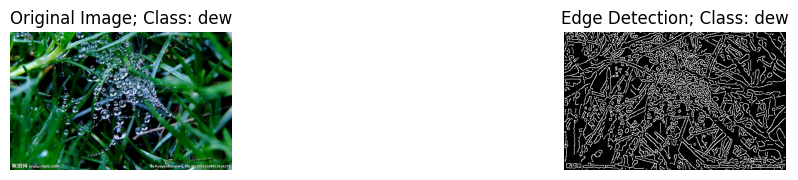

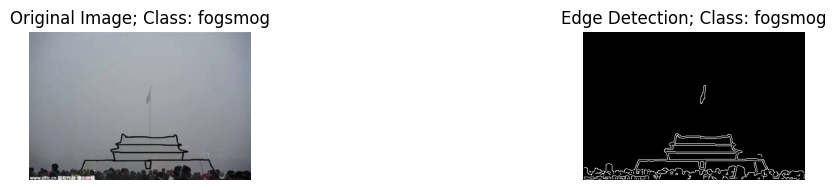

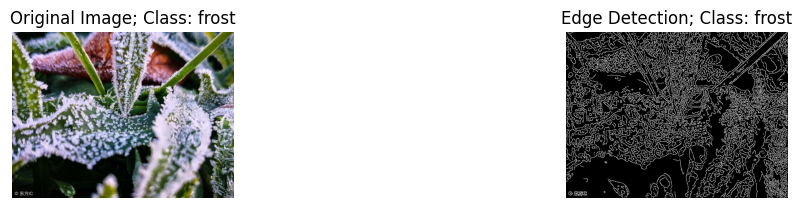

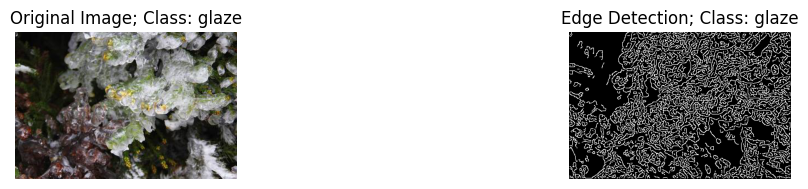

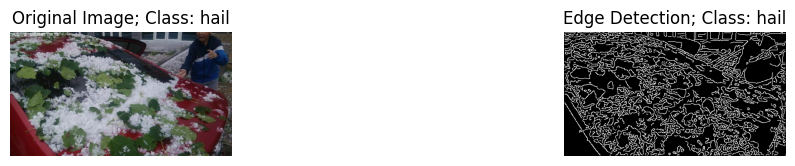

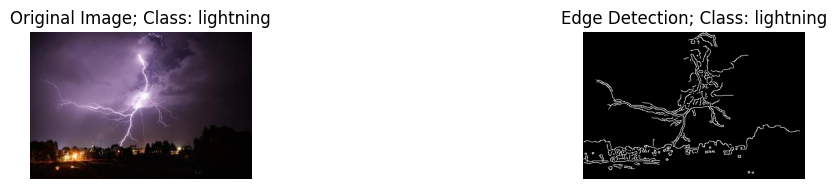

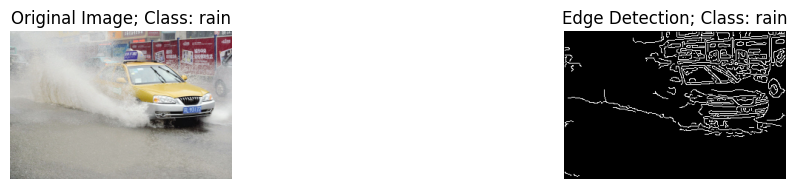

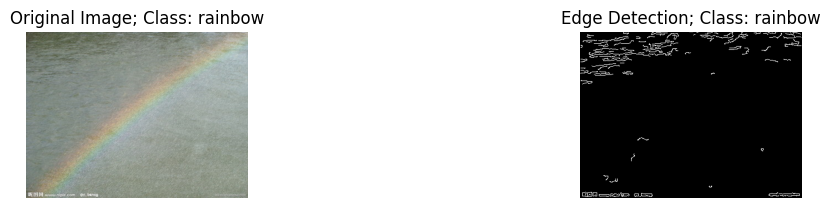

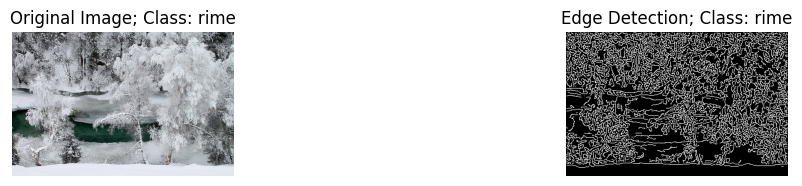

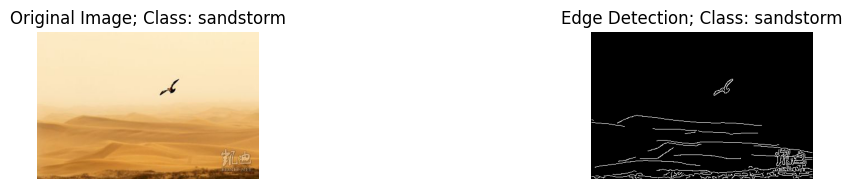

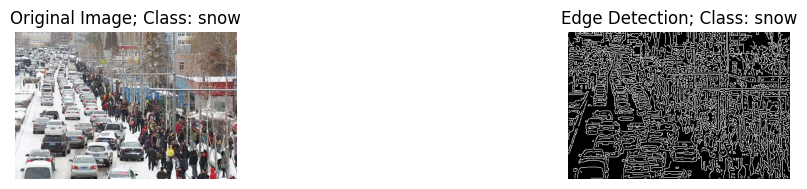

In [47]:
apply_canny_edge_detection()

In [131]:
def count_edges(image_classnames: dict) -> dict:
    edges_count = dict()
    for class_name, images in tqdm(image_classnames.items()):
        total_edges = 0
        for image in images:
            # Convert image to grayscale as Canny requires a single channel image
            gray_image = color.rgb2gray(image)
            gray_image = resize(gray_image, (512, 512), anti_aliasing=True)
            # Apply Canny edge detector
            edges = canny(gray_image, sigma=1.0)
            # Count the edges
            edge_count = np.sum(edges)
            total_edges += edge_count
        edges_count[class_name] = total_edges / len(images)
    return edges_count

In [132]:
edges_count = count_edges(image_classnames)
edges_count

100%|██████████| 11/11 [02:37<00:00, 14.31s/it]


{'dew': 17010.252148997133,
 'fogsmog': 6317.189189189189,
 'frost': 46301.357894736844,
 'glaze': 40070.80438184663,
 'hail': 31849.688663282574,
 'lightning': 8541.559681697612,
 'rain': 31647.102661596957,
 'rainbow': 8380.599137931034,
 'rime': 38758.520689655175,
 'sandstorm': 7871.156069364162,
 'snow': 32520.55072463768}

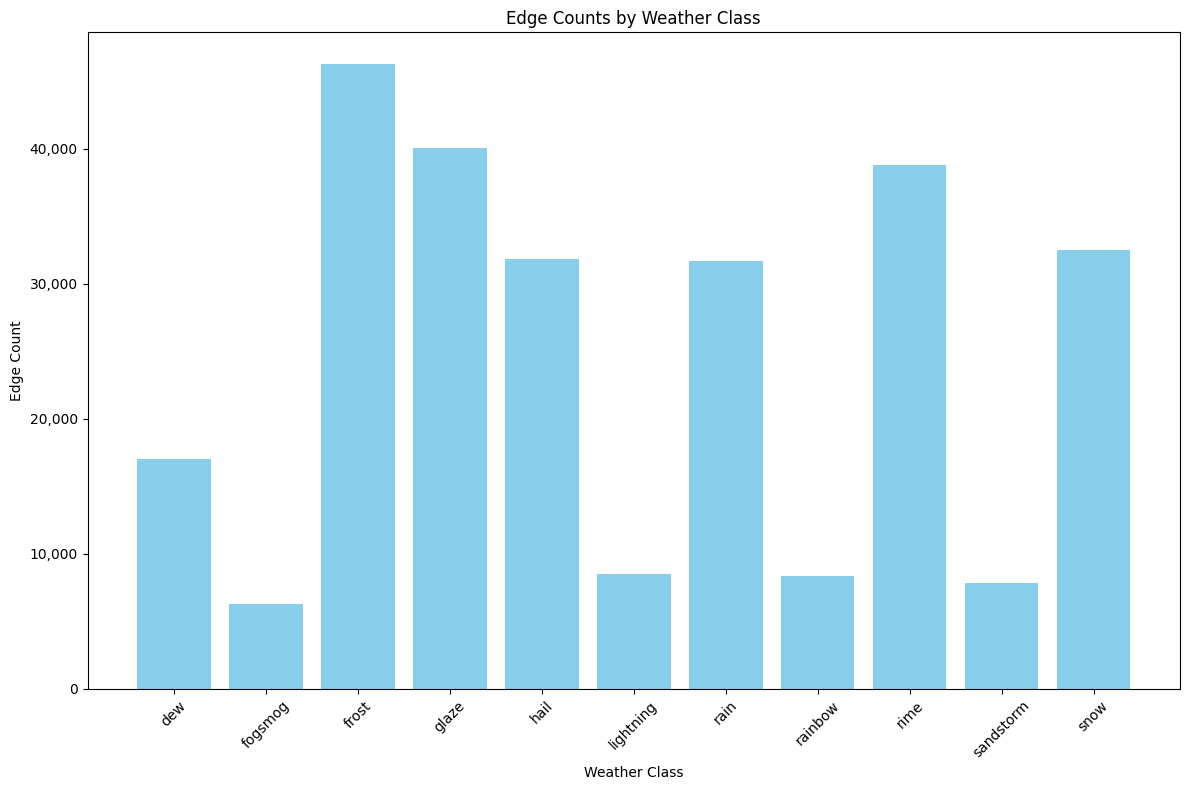

In [133]:
def plot_dict(d: dict, title: str, ylabel: str):
    classes = list(d.keys())
    values = list(d.values())
    
    # Create a bar chart
    plt.figure(figsize=(12, 8))  # Set the figure size as needed
    plt.bar(classes, values, color='skyblue')  # You can choose any color that suits your presentation

    # Add title and labels
    plt.title(title)
    plt.xlabel('Weather Class')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)  # Rotate class names for better readability

    # Add thousands separators to the y-axis
    if "Edge Count" in ylabel:
        plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    # Show the plot
    plt.tight_layout()  # Adjust subplots to give some padding
    plt.show()

plot_dict(edges_count, "Edge Counts by Weather Class", "Edge Count")

### Analysis of Edge Counts by Weather Class

#### Observations:

- **High Edge Count**: The classes `Frost`, `Rime` and `Glaze` have the highest edge counts, suggesting that these conditions typically feature highly textured visual patterns that are rich in edges. This might be due to the presence of ice in glaze conditions and swirling sands in sandstorms, both of which create complex patterns.
- **Low Edge Count**: Conversely, `Fogsmog`, `Sandstorm`, `Lightning` and `Rainbow` classes show relatively low edge counts. Rain images may have fewer edges due to the generally smooth and less textured appearance of raindrops or overcast skies. Rainbows, despite their distinct visual appearance, might not cover enough pixels in images to create a high count of edges.
- **Moderate Edge**: `Due`, `Rain`, `Hail`, `Rain` and `Snow` have moderate edge counts, indicating a balance between textured and smooth features within these images. Snow scenes might include both smooth snowy areas and more textured scenes where objects protrude through the snow, while fogsmog typically softens edges in images.


In [134]:
def density_edges(image_classnames: dict) -> dict:
    edges_density = dict()
    for class_name, images in tqdm(image_classnames.items()):
        total_edges = 0
        total_pixels = 0  # Initialize the total number of pixels

        for image in images:
            # Convert image to grayscale as Canny requires a single channel image
            gray_image = color.rgb2gray(image)
            gray_image = resize(gray_image, (512, 512), anti_aliasing=True)
            # Apply Canny edge detector
            edges = canny(gray_image, sigma=1.0)
            # Count the edges
            edge_count = np.sum(edges)
            total_edges += edge_count
            # Add the total number of pixels in the current image
            total_pixels += gray_image.size  # gray_image.size returns the total number of pixels in the image

        # Calculate edge density for the class
        density = total_edges / total_pixels if total_pixels > 0 else 0
        edges_density[class_name] = density / len(images)

    return edges_density

In [135]:
edges_density = density_edges(image_classnames)
edges_density

100%|██████████| 11/11 [02:35<00:00, 14.12s/it]


{'dew': 9.296412945611912e-05,
 'fogsmog': 2.8317466893579097e-05,
 'frost': 0.0003718435018016361,
 'glaze': 0.00023921437857093053,
 'hail': 0.00020557854527044264,
 'lightning': 8.642828743221386e-05,
 'rain': 0.00022951352849457713,
 'rainbow': 0.0001377993474817446,
 'rime': 0.00012745864042629102,
 'sandstorm': 4.339028545536285e-05,
 'snow': 0.00019976820599983006}

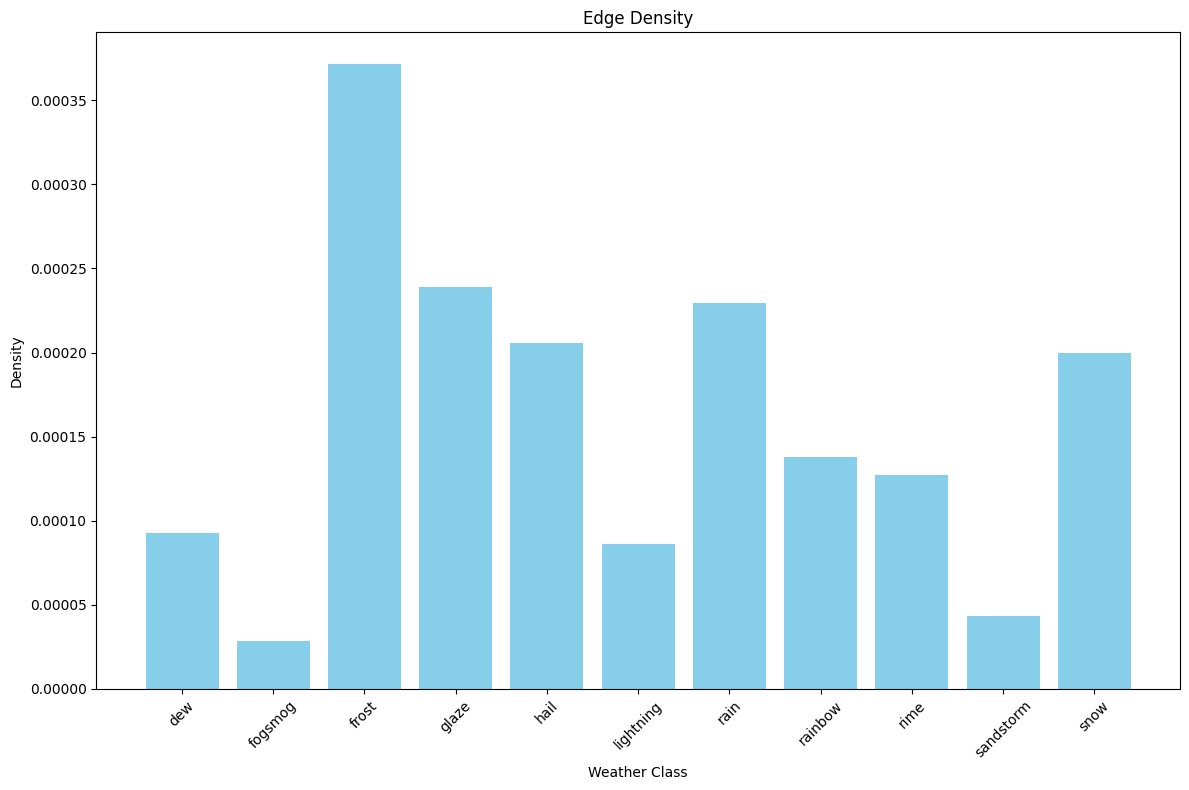

In [136]:
plot_dict(edges_density, "Edge Density", "Density")

### Analysis of Edge Density by Weather Class

#### Key Observations:

- **High Edge Density in Glaze and Frost**: These classes show the highest edge densities. Typically, glaze involves ice formation on surfaces, and frost appears under conditions of freezing atmospheric moisture, both creating intricate patterns and textures captured as edges.
- **Low Edge Density in Fogsmog and Rain**: These weather conditions typically result in images with smooth textures and fewer clear edges. Fog and rain create diffuse and uniform scenes with few abrupt changes in pixel intensity, which explains the lower edge densities.
- **Variable Edge Density**: Snow, sandstorm, and hail display moderate to high edge densities, suggesting a mix of smooth and textured features in these images. Snow scenes can vary widely depending on the presence of undisturbed snow versus a landscape with multiple interruptions like footprints or melting patterns. Sandstorms may have swirling patterns that create transient edges, while hail involves distinct ice balls that contrast sharply with the background.


In [137]:
def calculate_edge_lengths(image_classnames: dict) -> dict:
    edge_lengths = dict()

    for class_name, images in tqdm(image_classnames.items()):
        total_edge_length = 0

        for image in images:
            # Convert image to grayscale
            gray_image = color.rgb2gray(image)
            gray_image = transform.resize(gray_image, (512, 512), anti_aliasing=True)

            # Apply Canny edge detector
            edges = feature.canny(gray_image, sigma=1.0)

            # Convert edges image to uint8 because findContours expects this type
            edges_uint8 = (edges * 255).astype(np.uint8)

            # Find contours
            contours, _ = cv2.findContours(edges_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Calculate the total length of all contours
            for contour in contours:
                total_edge_length += cv2.arcLength(contour, closed=False)

        # Normalize by the number of images if needed or just sum up lengths
        average_edge_length = total_edge_length / len(images) if len(images) > 0 else 0
        edge_lengths[class_name] = average_edge_length

    return edge_lengths


In [143]:
edges_lengths = calculate_edge_lengths(image_classnames)

100%|██████████| 11/11 [02:56<00:00, 16.02s/it]


{'dew': 27456.72288696933, 'fogsmog': 10446.260178271388, 'frost': 75324.03421257596, 'glaze': 65394.36622665186, 'hail': 51428.98404780701, 'lightning': 14394.470835557982, 'rain': 51525.89532918826, 'rainbow': 14089.588321240812, 'rime': 62935.329739033456, 'sandstorm': 12750.101642730953, 'snow': 52817.88990442054}


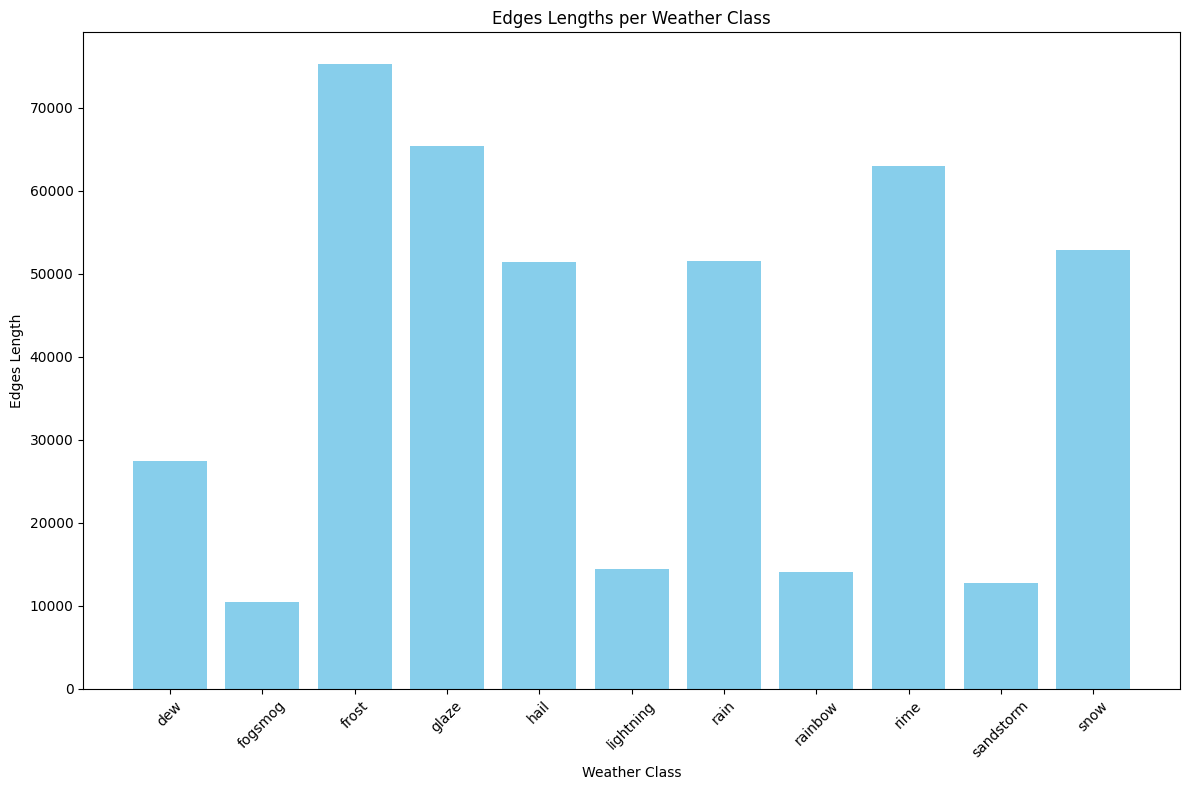

In [145]:
print(edges_lengths)
plot_dict(edges_lengths, "Edges Lengths per Weather Class", "Edges Length")

### Analysis of edge lenght by Weather Class

#### Observations:

- **High Edge Length in Glaze and Frost**: Glaze and Frost classes exhibit the highest edge lengths, indicating that these weather conditions often involve intricate textures that result in extended edges. This might be due to the crystalline forms of ice and frost that create continuous, complex patterns.
- **Low Edge Length in Fogsmog and Rain**: Notably lower edge lengths in Fogsmog and Rain suggest that these conditions typically result in images with smoother textures and fewer distinct boundaries, as these weather types tend to obscure and soften visual features.
- **Moderate to High Edge Length in Sandstorm and Snow**: Sandstorm and Snow display significant edge lengths, although not as high as Frost or Glaze. This reflects the varying nature of these conditions—sandstorms may have swirling sands that create transient, albeit defined, edges, whereas snow can vary from smooth surfaces of undisturbed snow to rough, uneven surfaces when disturbed.
- **Variability Across Other Classes**: Lightning, Rain, and Rainbow show variable edge lengths, which can be attributed to the transient and dynamic nature of these weather phenomena. Lightning, for example, though it can create stark, linear edges, is usually captured against a relatively smooth background, limiting the total edge length.
